# Autoencoder for Fashion MNIST and CIFAR-100

## Project Overview

In this project, you will implement an Autoencoder to explore and generate hybrid images by combining feature vectors from different classes. This notebook focuses on using the **Fashion MNIST** dataset, and as a challenge, you will later apply the same methodology to the **CIFAR-100** dataset.

**Tasks:**
1. Dataset Preparation and Filtering
2. Autoencoder Implementation
3. Training the Autoencoder
4. Class Feature Centroid Calculation
5. Average Image Creation
6. Hybrid Image Generation
7. CIFAR-100 Challenge Exercise

Final Goal. Create hybrid objects. E.g. First a hybrid between a sneaker and a t-shirt and later a hybrid between a car and a plane.

**Important**: At the end you should write a report of adequate size, which will probably mean at least half a page. In the report you should describe how you approached the task. You should describe:
- Encountered difficulties (due to the method, e.g. "not enough training samples to converge", not technical like "I could not install a package over pip")
- Steps taken to alleviate difficulties
- General description of what you did, explain how you understood the task and what you did to solve it in general language, no code.
- Potential limitations of your approach, what could be issues, how could this be hard on different data or with slightly different conditions
- If you have an idea how this could be extended in an interesting way, describe it.

### Benjamin廖宇521260910005 & Florian方俊杰521260910018


## Step 1: Dataset Preparation

We will work with the **Fashion MNIST** dataset, which contains 10 classes of grayscale images representing items of clothing.

### Your Tasks:
1. Load the Fashion MNIST dataset using `torchvision.datasets`.
2. Apply necessary transformations, including:
   - Normalization to scale pixel values.
   - Resizing if needed.
3. Create training and validation DataLoaders for efficient data loading.

### Hints:
- Use `torchvision.transforms` for preprocessing.
- Normalize images to have mean `0.5` and standard deviation `0.5`.

Start by writing your code to load and preprocess the dataset.


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import List, Callable, Union, Any, TypeVar, Tuple
from torch import nn
from abc import abstractmethod
import unittest
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans
from itertools import combinations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

CIFAR_PATH = "./data_CIFAR100"
mean = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
std = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]
num_workers= 2

def cifar100_dataset(args):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # 数据增强
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    transform_test = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean, std)])

    cifar100_training = datasets.CIFAR100(root=CIFAR_PATH, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(cifar100_training, batch_size=args.bs, shuffle=True, num_workers=num_workers)
        
    cifar100_testing = datasets.CIFAR100(root=CIFAR_PATH, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(cifar100_testing, batch_size=100, shuffle=False, num_workers=num_workers)
    
    return trainloader,testloader

train_loader, test_loader = cifar100_dataset()


for images, labels in train_loader:
    print(f'Image batch dimensions: {images.shape}')
    print(f'Label batch dimensions: {labels.shape}')
    break  

Image batch dimensions: torch.Size([64, 1, 32, 32])
Label batch dimensions: torch.Size([64])


In [3]:
# 0 - T-shirt
# 1 - Trouser
# 2 - Pullover
# 3 - Dress
# 4 - Coat
# 5 - Sandal
# 6 - Shirt
# 7 - Sneaker
# 8 - Bag
# 9 - Ankle boot
Label = {0:'T-shirt',
         1:'Trouser',
         2:'Pullover',
         3:'Dress',
         4:'Coat',
         5:'Sandal',
         6:'Shirt',
         7:'Sneaker',
         8:'Bag',
         9:'Ankle boot'}


## Step 2: Autoencoder Implementation

Define the architecture of your Autoencoder. It should consist of:
1. **Encoder**: A series of convolutional layers to reduce the spatial dimensions of the input image.
2. **Decoder**: A series of transpose convolutional layers to reconstruct the image from its latent representation.

### Your Tasks:
1. Implement the encoder and decoder parts of the Autoencoder.
2. Ensure the model takes grayscale images (1 input channel) and outputs images of the same shape.

### Hints:
- Use `nn.Conv2d` and `nn.ConvTranspose2d`.
- Add non-linear activations like `ReLU` between layers.
- Use `Tanh` or `Sigmoid` for the final activation in the decoder.

Write your Autoencoder model below.


In [4]:
Tensor = TypeVar('torch.tensor')

In [6]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [7]:
from torch.nn import functional as F

class BetaVAE(BaseVAE):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.out_channels = in_channels
        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128]
            
        self.hidden_dims = hidden_dims
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim) #64:
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*16)
    
        reversed_hidden_dims = list(reversed(hidden_dims))

        for i in range(len(reversed_hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(reversed_hidden_dims[i],
                                       reversed_hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(reversed_hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(reversed_hidden_dims[-1],
                                               reversed_hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(reversed_hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(reversed_hidden_dims[-1], out_channels=self.out_channels, #3
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        # print(self.hidden_dims)
        # raise RuntimeError
        result = result.view(-1, self.hidden_dims[-1], 4, 4) #(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [7]:
class TestVAE(unittest.TestCase):

    def setUp(self) -> None:
        # self.model2 = VAE(3, 10)
        self.model = BetaVAE(1, 10, loss_type='H').to(device)

    def test_summary(self):
        print(summary(self.model, (1, 32, 32), device=device))
        # print(summary(self.model2, (3, 64, 64), device='cpu'))

    def test_forward(self):
        x = torch.randn(64, 1, 32, 32).to(device)
        y = self.model(x)
        print("Model Output size:", y[0].size())
        # print("Model2 Output size:", self.model2(x)[0].size())

    def test_loss(self):
        x = torch.randn(64, 1, 32, 32).to(device)

        result = self.model(x)
        loss = self.model.loss_function(*result, M_N = 0.005)
        print(loss)


test_vae = TestVAE()
test_vae.setUp()
test_vae.test_summary()
test_vae.test_forward()
test_vae.test_loss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Linear-10                   [-1, 10]          20,490
           Linear-11                   [-1, 10]          20,490
           Linear-12                 [-1, 2048]          22,528
  ConvTranspose2d-13             [-1, 64, 8, 8]          73,792
      BatchNorm2d-14             [-1, 6


## Step 3: Training the Autoencoder

Train your Autoencoder to reconstruct images from the Fashion MNIST dataset.

### Your Tasks:
1. Define a suitable loss function (e.g., Mean Squared Error).
2. Set up an optimizer like Adam.
3. Write a training loop to:
   - Pass inputs through the Autoencoder.
   - Compute the reconstruction loss.
   - Backpropagate and update weights.

4. Visualize the reconstructed images periodically during training.

### Hints:
- Use GPU acceleration if available (`.cuda()`).
- Visualize outputs using `matplotlib`.

Write your training loop below.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAE(1, 10, loss_type="H").to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [9]:
for batch_idx, (data, _) in enumerate(train_loader):
    data=data.to(device)
    print(len(model(data)[0][0]))
    print(len(data[0]))
    # print(model.forward(data)[0][0][0])
    break

1
1


In [10]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, _, mu, log_var = model(data)
        loss = model.loss_function(recon_batch, data, mu, log_var, M_N=0.005)
        loss["loss"].backward()
        optimizer.step()
        total_loss += loss['loss'].item()
        
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')



100%|██████████| 938/938 [00:07<00:00, 119.59it/s]


Epoch 1, Loss: 0.1942018360407876


100%|██████████| 938/938 [00:08<00:00, 104.93it/s]


Epoch 2, Loss: 0.17685940348580956


100%|██████████| 938/938 [00:11<00:00, 80.41it/s]

Epoch 3, Loss: 0.17424071100411384


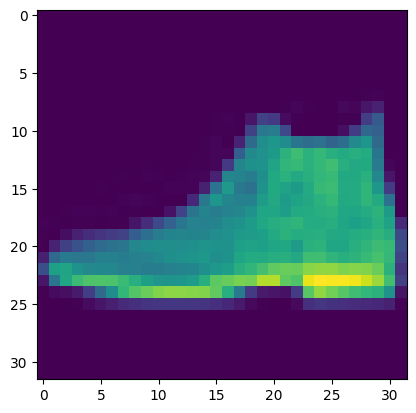

In [11]:
img, class_idx = next(iter(test_loader))
plt.imshow(img[0][0])

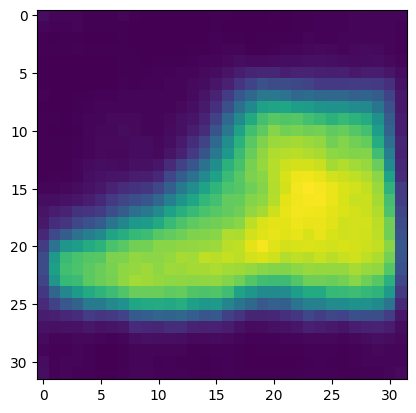

In [12]:
y = model.generate(img.to(device))
# print(type(img[0][0]))
plt.imshow(y.to('cpu').detach().numpy()[0][0])


## Step 4: Latent Space Analysis

Once the Autoencoder is trained, explore the latent space.

### Your Tasks:
1. Pass a batch of images through the encoder and store the latent representations.
2. Compute the **centroids** (average latent vectors) for each Fashion MNIST class.
3. Visualize the latent space using dimensionality reduction techniques like PCA or t-SNE.

### Hints:
- Use `sklearn.decomposition.PCA` or `sklearn.manifold.TSNE` for visualization.
- Compute centroids by averaging latent vectors of images from the same class.

Write your code to analyze the latent space below.


In [ ]:
datas = []
labels = []
for data, target in train_loader.dataset:
    datas.append(data)
    labels.append(target)

datas = torch.stack(datas).to(device)  

mu, logvar = model.encode(datas)
preds_latent = model.reparameterize(mu, logvar)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results_reparam = tsne.fit_transform(preds_latent.detach().cpu().numpy())


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.040s...
[t-SNE] Computed neighbors for 60000 samples in 13.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

In [8]:
num_samples = 1000

indices = np.random.choice(len(tsne_results_reparam), num_samples, replace=False)
tsne_results_reparam_sampled = tsne_results_reparam[indices]
labels_sampled = np.array(labels)[indices]


In [15]:
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(tsne_results_reparam)
cluster_centers = kmeans.cluster_centers_

cluster_labels = kmeans.labels_
cluster_centers_labels = np.array(labels)[cluster_labels]

/tmp/ipykernel_23938/2356895889.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', cmap='viridis', s=50, )
/tmp/ipykernel_23938/2356895889.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


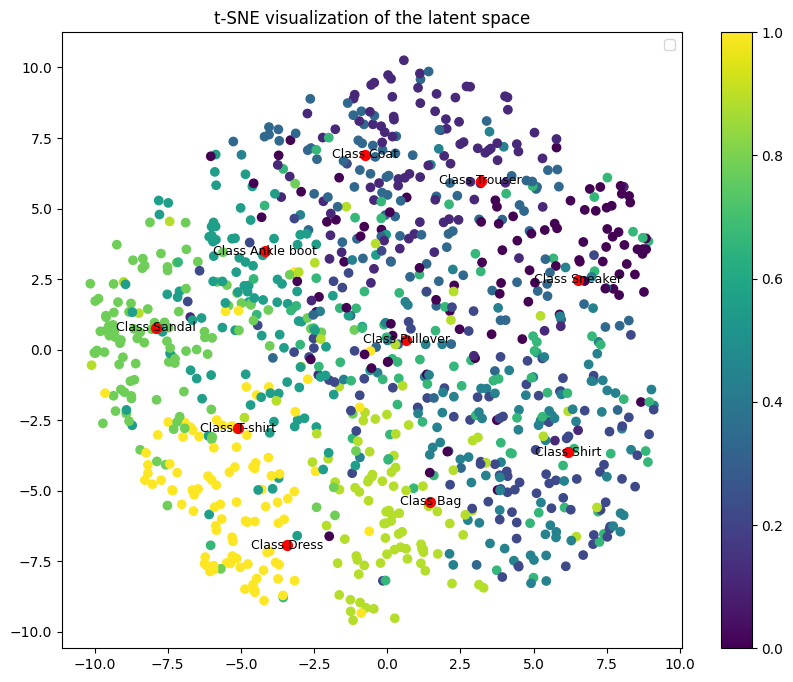

In [16]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results_reparam_sampled[:, 0], tsne_results_reparam_sampled[:, 1], c=labels_sampled, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', cmap='viridis', s=50, ) 
for i, (x, y) in enumerate(cluster_centers):
    plt.text(x, y, f'Class {Label[i]}', fontsize=9, ha='center', va='center') 
plt.colorbar()
plt.title('t-SNE visualization of the latent space')
plt.legend()
plt.show()


## Step 5: Hybrid Image Generation

Using the latent space centroids, you can create hybrid images by interpolating between centroids of two classes.

### Your Tasks:
1. Select two class centroids (e.g., "T-shirt" and "Sneaker").
2. Linearly interpolate between the centroids with a parameter `alpha` in [0, 1].
3. Decode the interpolated latent representations back into image space.

### Hints:
- Use a simple linear interpolation formula: `(1 - alpha) * centroid1 + alpha * centroid2`.
- Visualize the hybrid images for different values of `alpha`.

Write your code to generate hybrid images below.


In [21]:
def interpolate_centroids(centroid1, centroid2, alpha):
    return (1 - alpha) * centroid1 + alpha * centroid2

In [22]:
def decode_latent(latent_vector, model):
    return model.decode(latent_vector.unsqueeze(0))

In [19]:
class_latent_representations = {}

for data, labels in train_loader:
    data = data.to(device) 
    labels = labels.to(device)
    
    mu, logvar = model.encode(data)
    latents = model.reparameterize(mu, logvar)
    
    for label in torch.unique(labels):
        label_latents = latents[labels == label]
        if label.item() not in class_latent_representations:
            class_latent_representations[label.item()] = label_latents
        else:
            class_latent_representations[label.item()] = torch.cat((class_latent_representations[label.item()], label_latents))

In [20]:
# print(class_latent_representations)

In [21]:
centroids = {label: torch.mean(latents, dim=0) for label, latents in class_latent_representations.items()}

In [22]:
print(centroids)

{0: tensor([-0.0102, -0.6765,  0.8701, -0.0637,  0.3062, -0.0311, -0.0204,  0.5348,
         0.0355,  0.0277], device='cuda:0', grad_fn=<MeanBackward1>), 1: tensor([ 0.0473, -0.2043,  1.2749, -0.0763, -1.0179, -0.0564,  0.0224, -0.2842,
         0.0212,  0.0871], device='cuda:0', grad_fn=<MeanBackward1>), 2: tensor([-0.0180, -0.3673,  0.1108,  0.0314,  0.8931, -0.0829,  0.0033, -0.4115,
        -0.0499,  0.0217], device='cuda:0', grad_fn=<MeanBackward1>), 3: tensor([ 0.0243,  0.0601,  1.1686, -0.0676, -0.3939, -0.0549, -0.0147,  0.4790,
         0.0052,  0.0438], device='cuda:0', grad_fn=<MeanBackward1>), 4: tensor([ 0.0154,  0.1476,  0.3791,  0.0139,  0.9034, -0.1074,  0.0127, -0.6255,
        -0.0085, -0.0018], device='cuda:0', grad_fn=<MeanBackward1>), 5: tensor([-0.0267, -0.1012, -0.6238, -0.0025, -0.9890,  0.0784,  0.0402,  0.3710,
         0.0081,  0.0295], device='cuda:0', grad_fn=<MeanBackward1>), 6: tensor([-0.0009, -0.2147,  0.3547, -0.0166,  0.5002, -0.0507,  0.0224, -0.0432

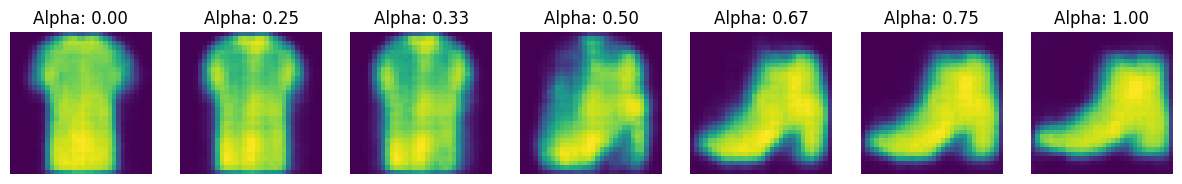

In [23]:
centroid1 = centroids[0]
centroid2 = centroids[9]

alphas = [0, 0.25, 1/3, 1/2, 2/3, 0.75, 1]
fig, axes = plt.subplots(1, len(alphas), figsize=(15, 5))

for i, alpha in enumerate(alphas):
    interpolated_latent = interpolate_centroids(centroid1, centroid2, alpha)
    reconstructed_image = decode_latent(interpolated_latent, model)
    axes[i].imshow(reconstructed_image[0].cpu().detach().squeeze())  
    axes[i].set_title(f'Alpha: {alpha:.2f}')
    axes[i].axis('off')

plt.show()

In [19]:
label_combinations = list(combinations(list(range(10)), 2))

In [41]:
print(len(label_combinations), label_combinations)

45 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


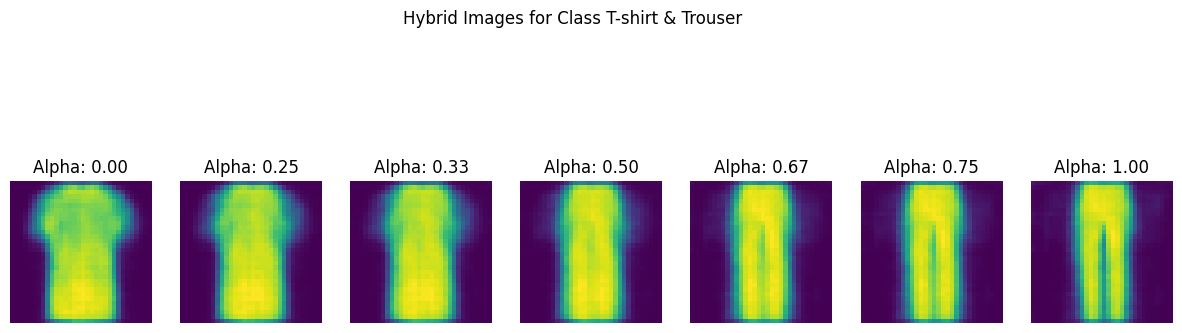

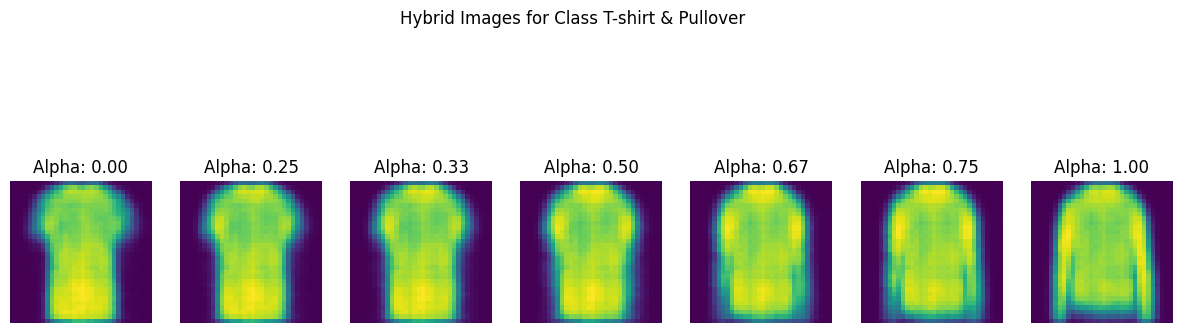

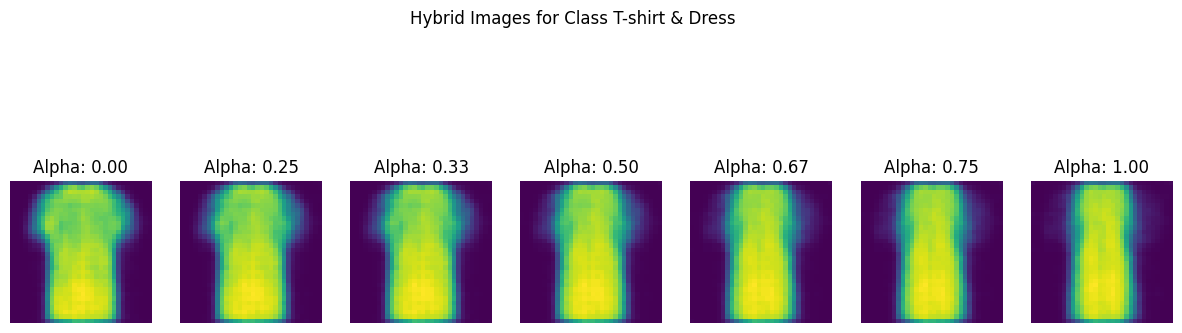

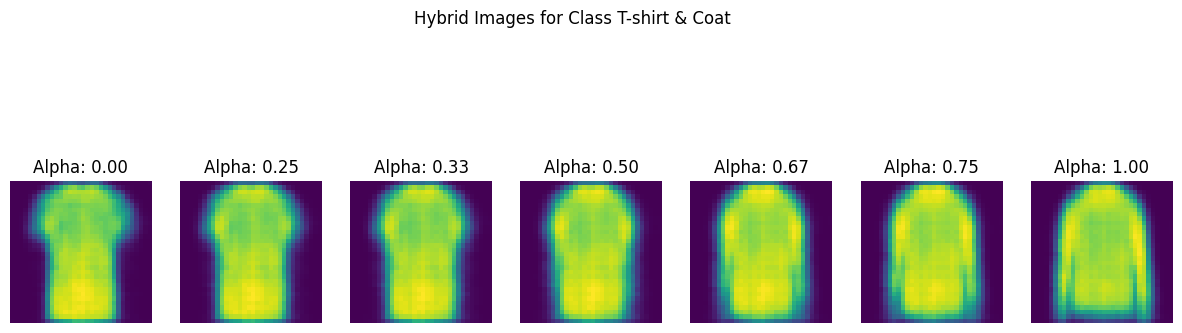

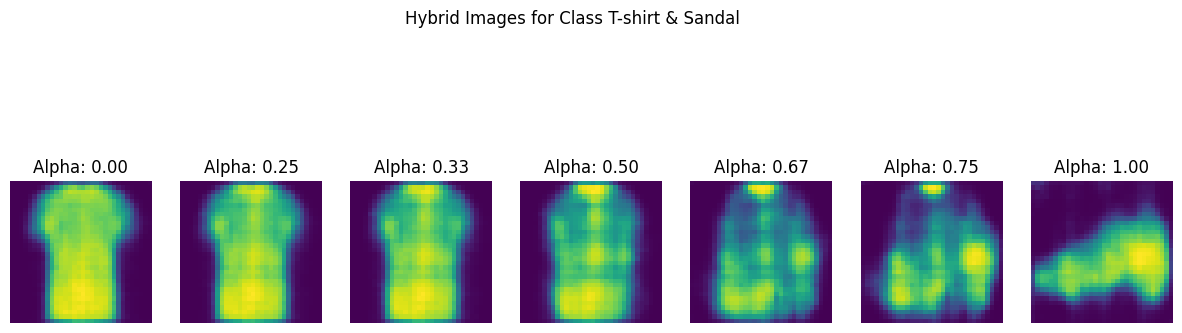

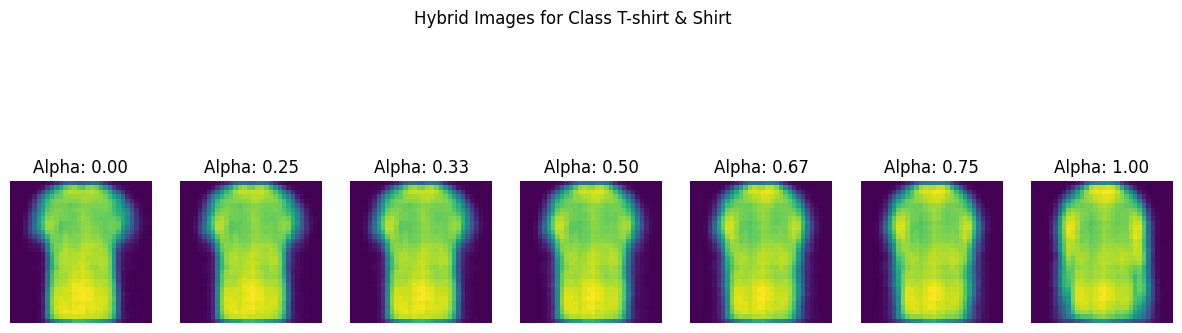

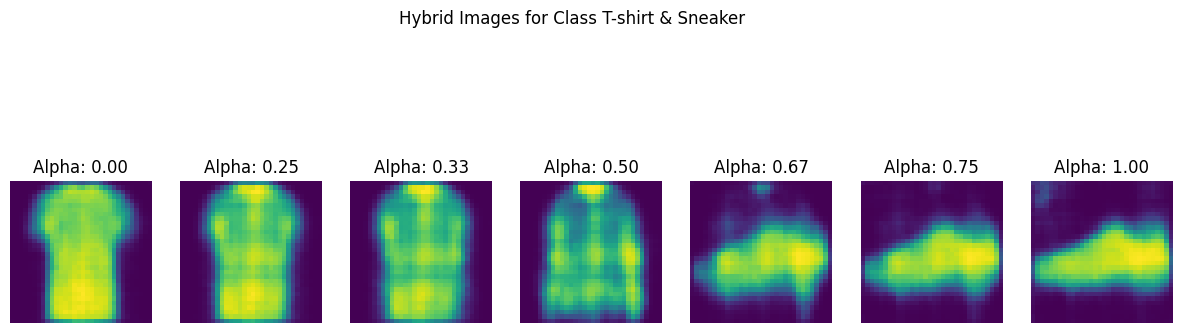

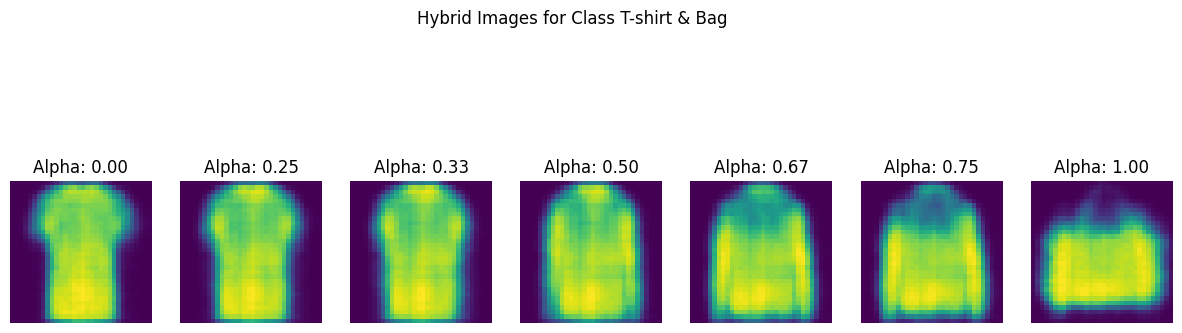

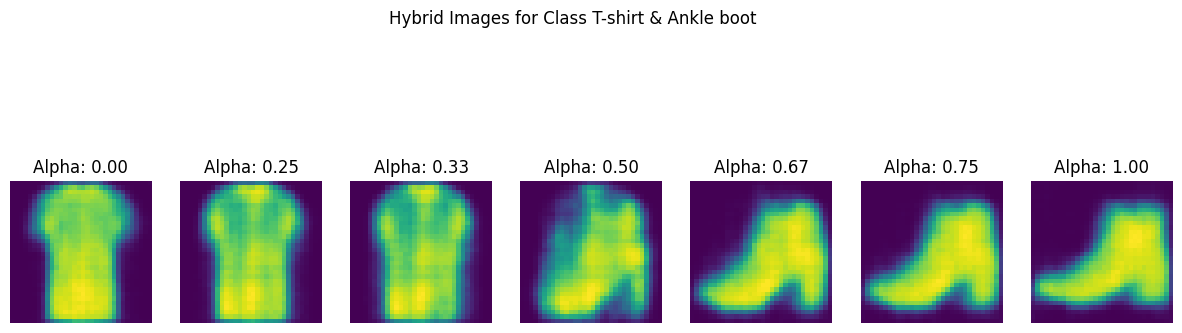

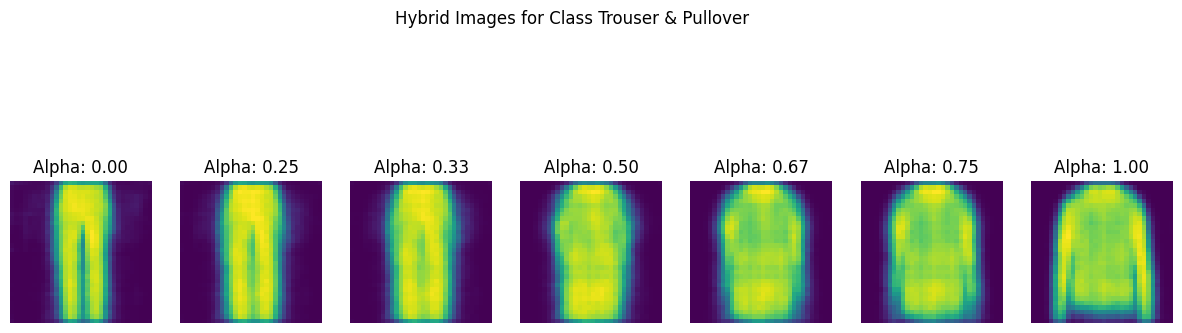

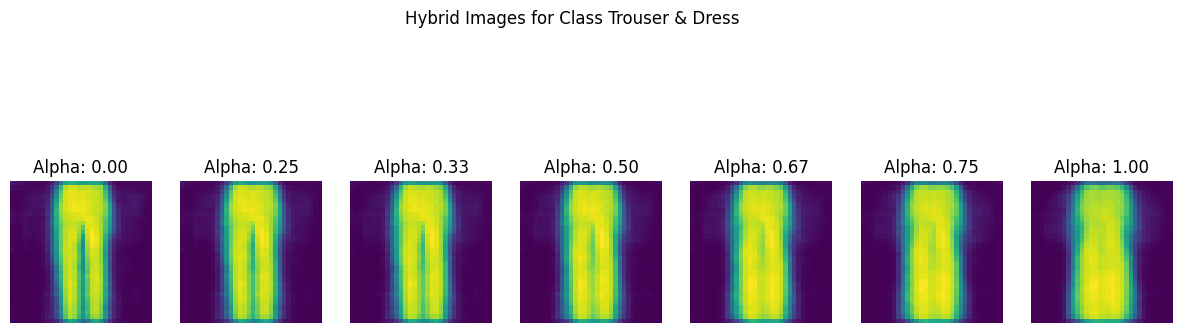

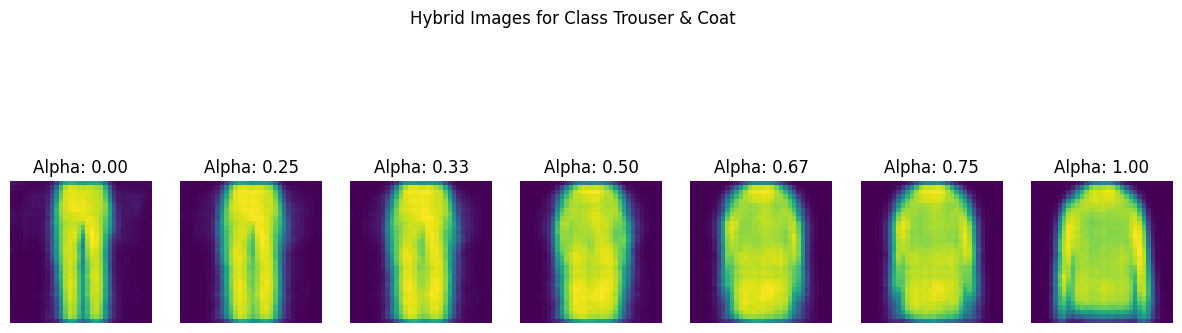

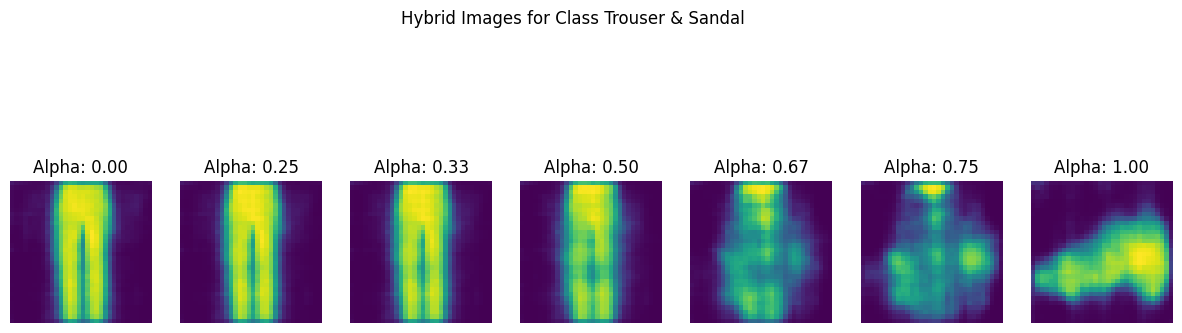

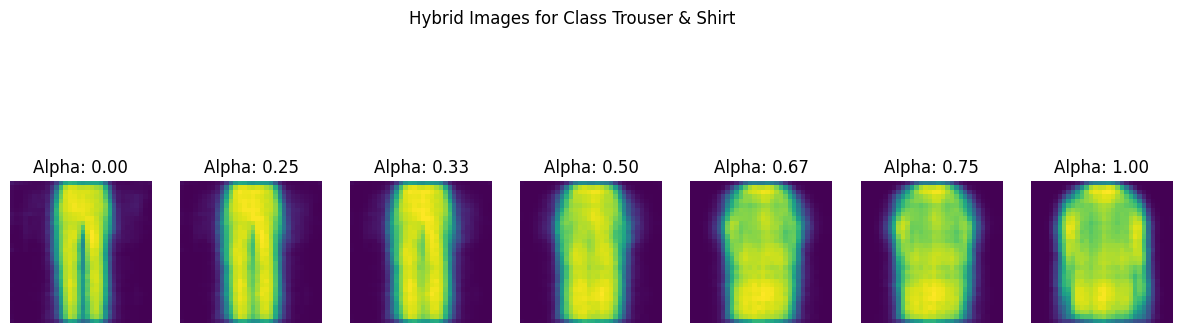

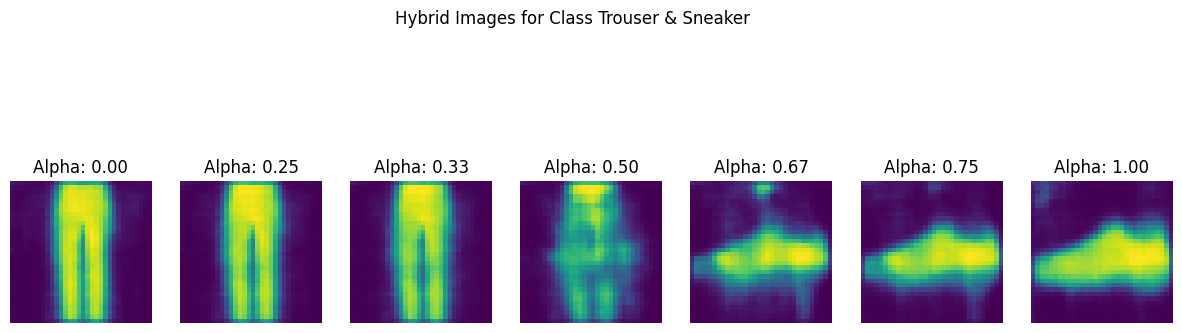

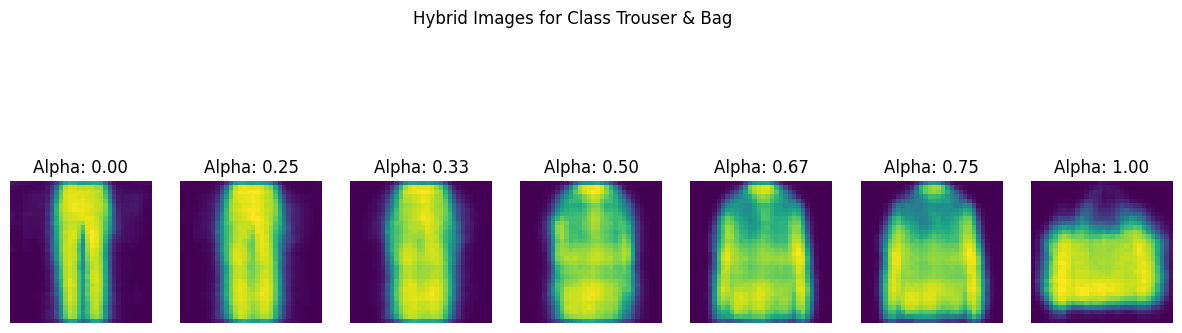

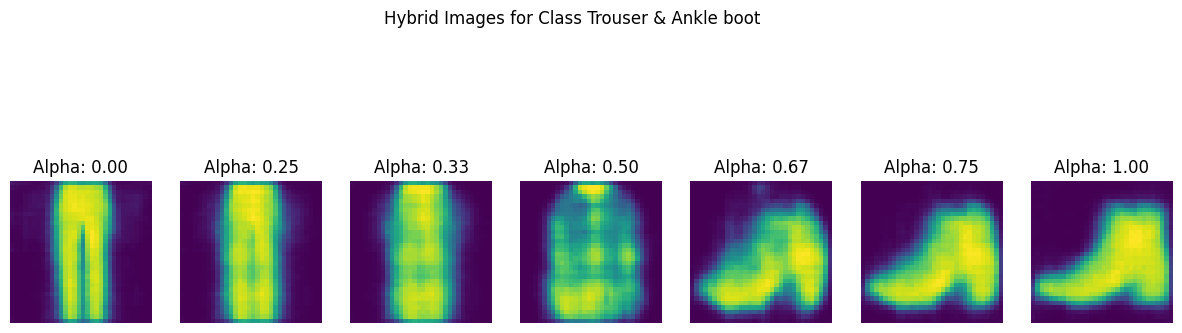

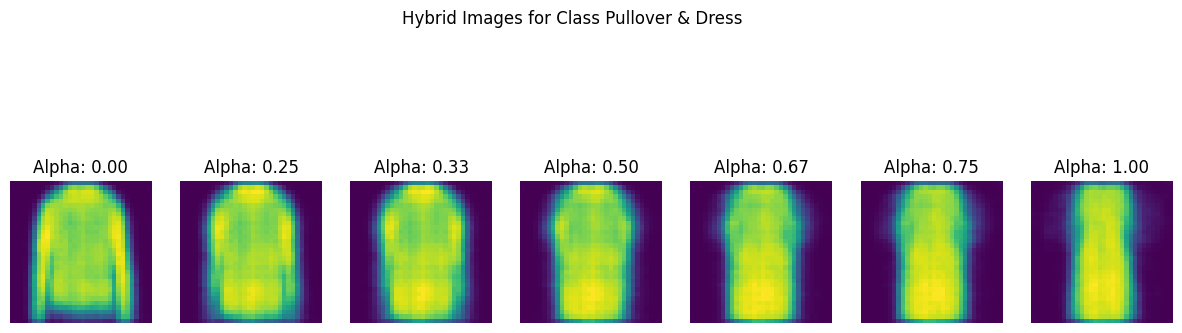

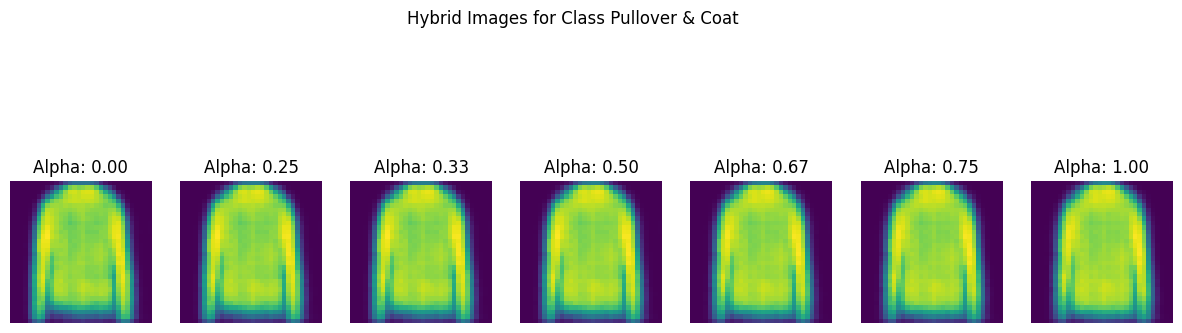

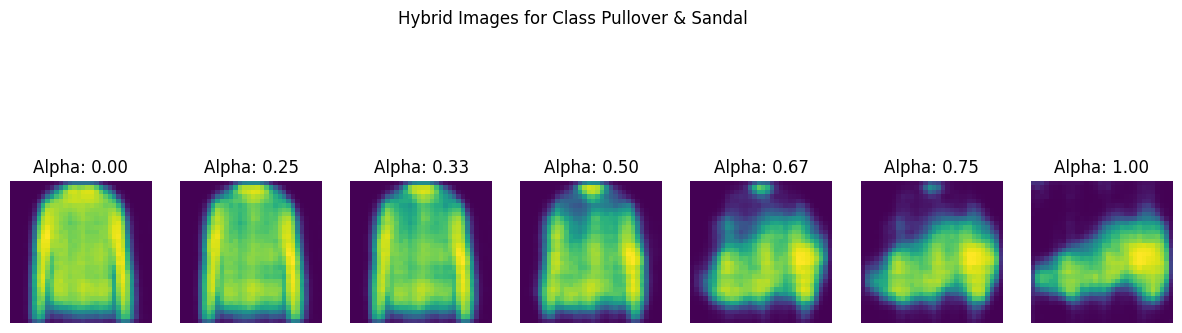

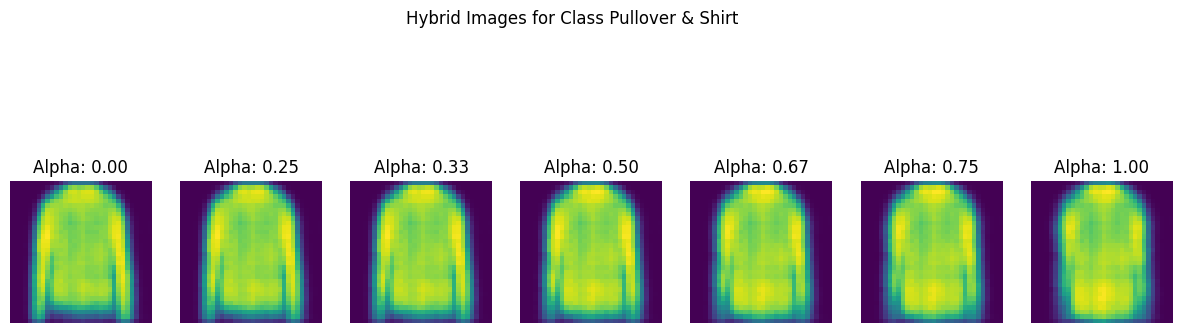

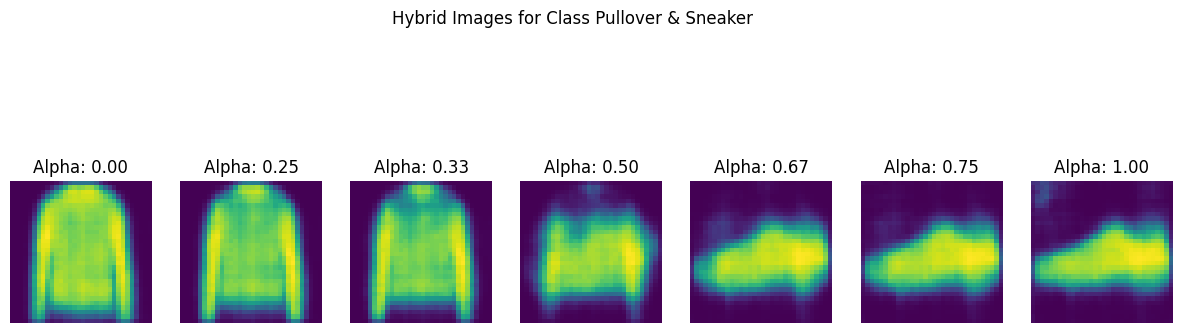

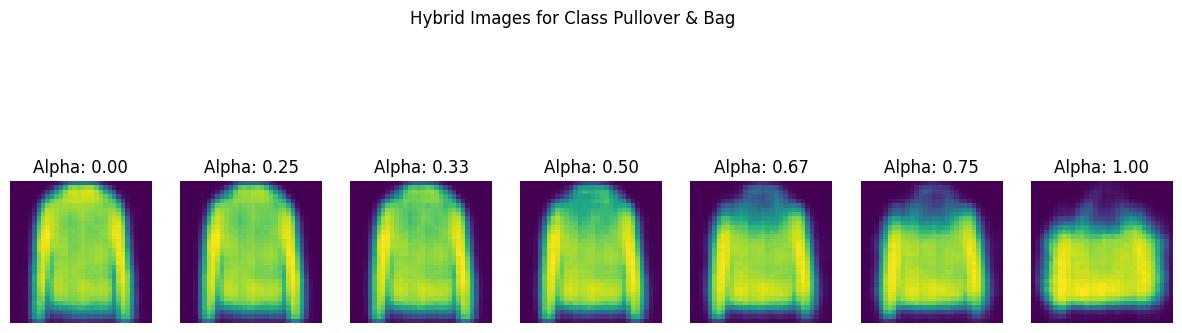

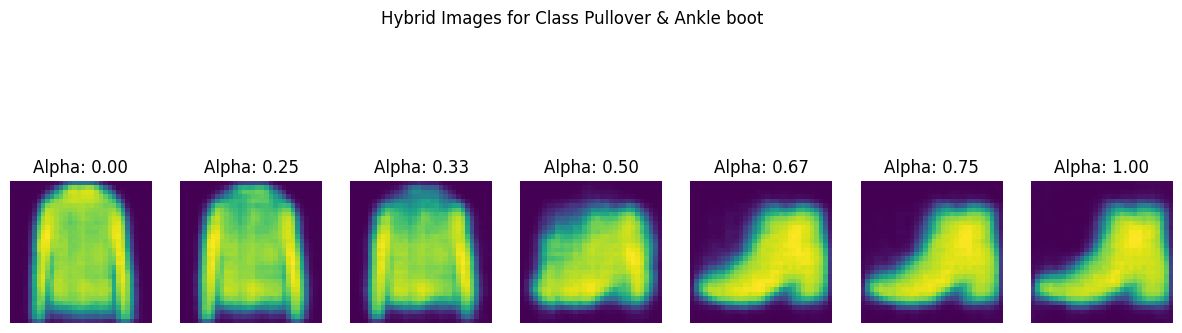

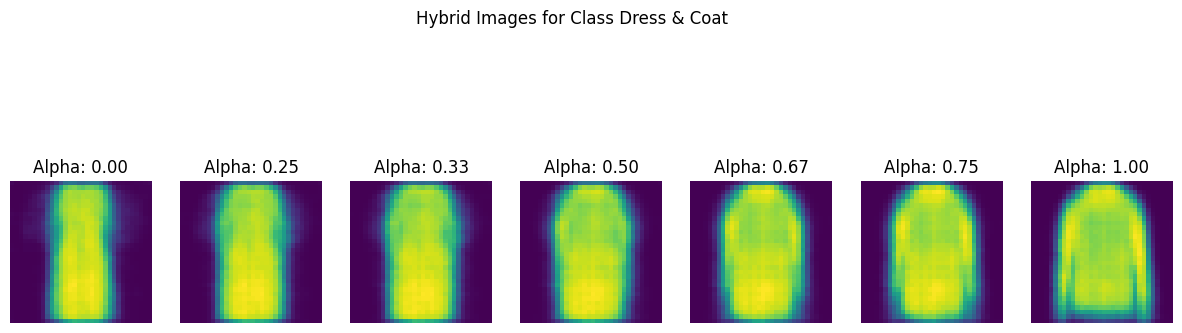

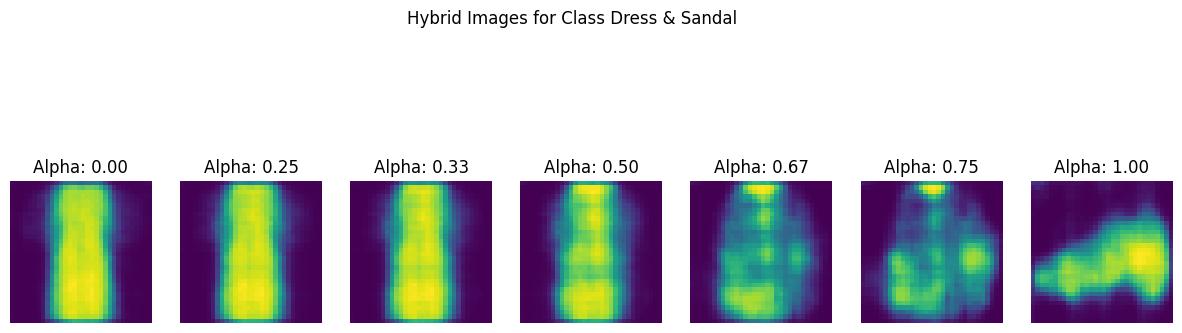

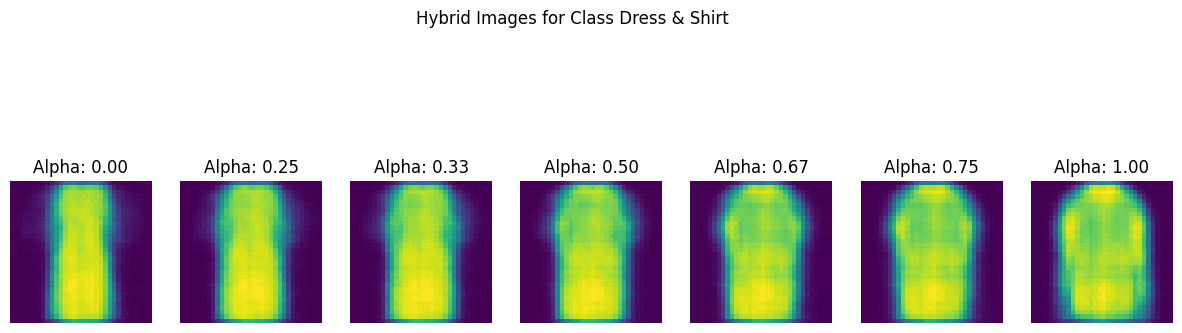

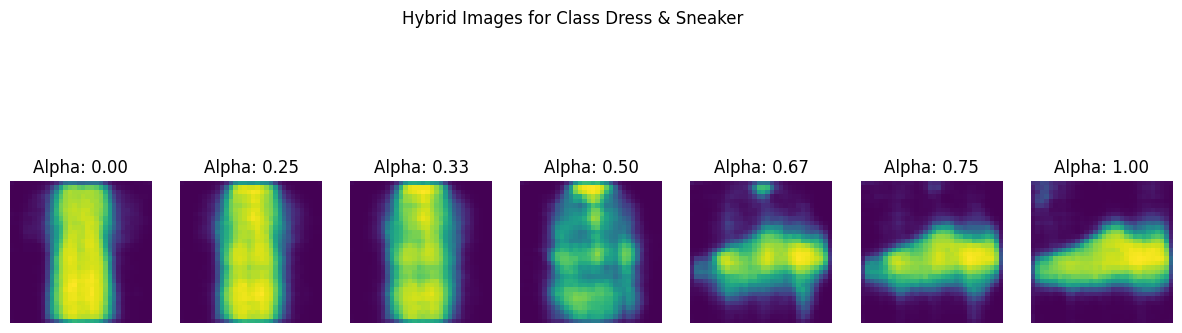

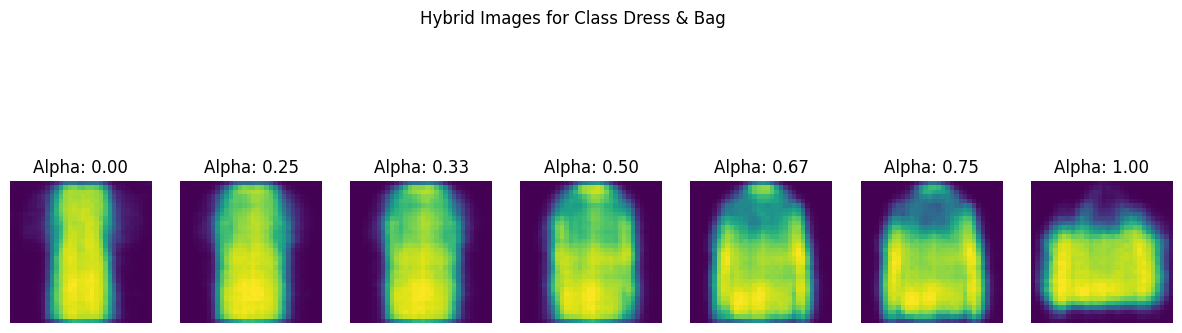

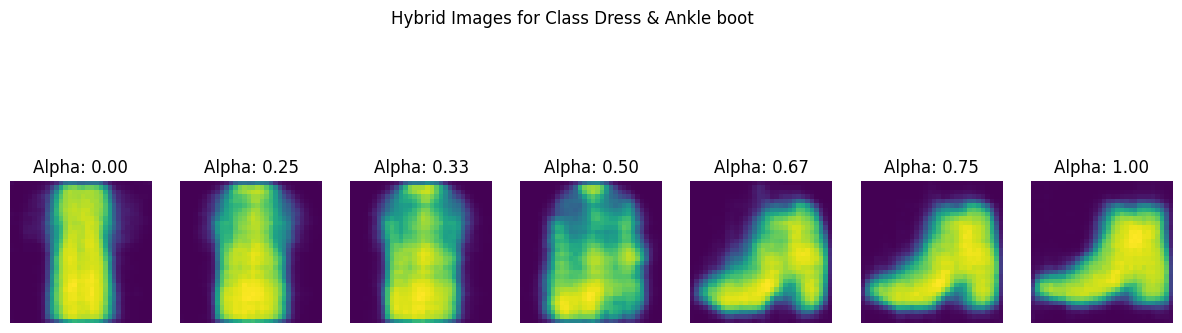

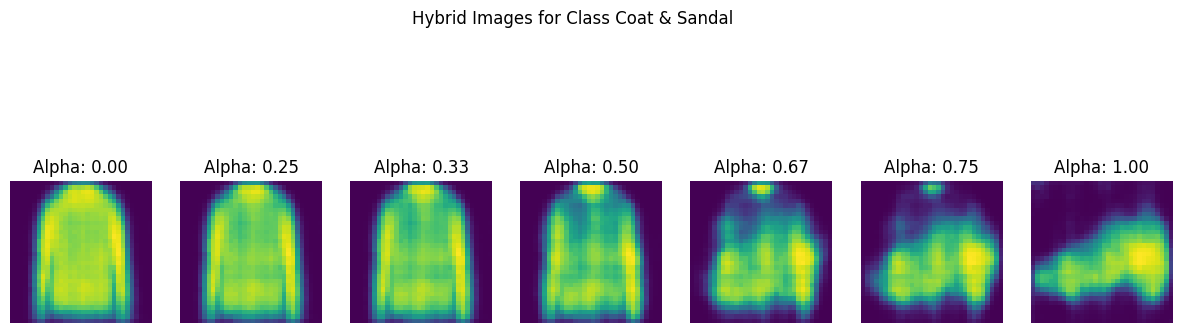

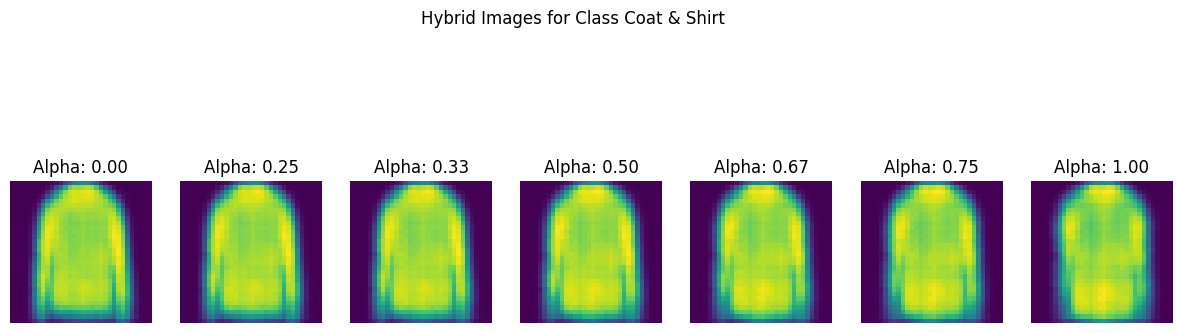

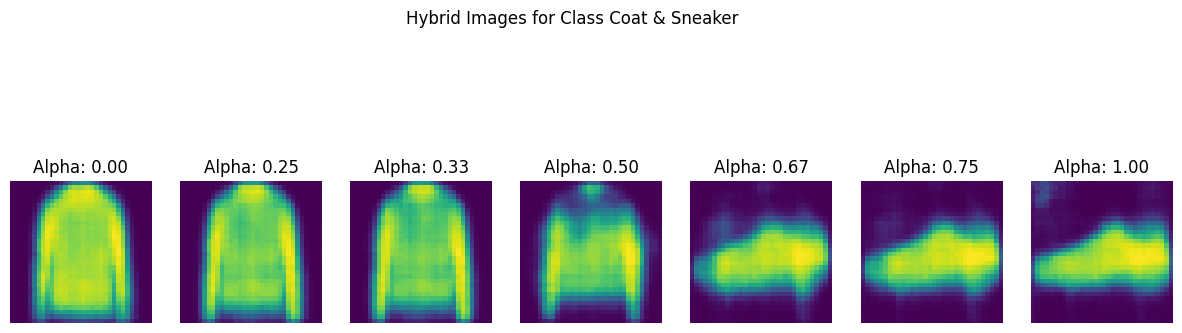

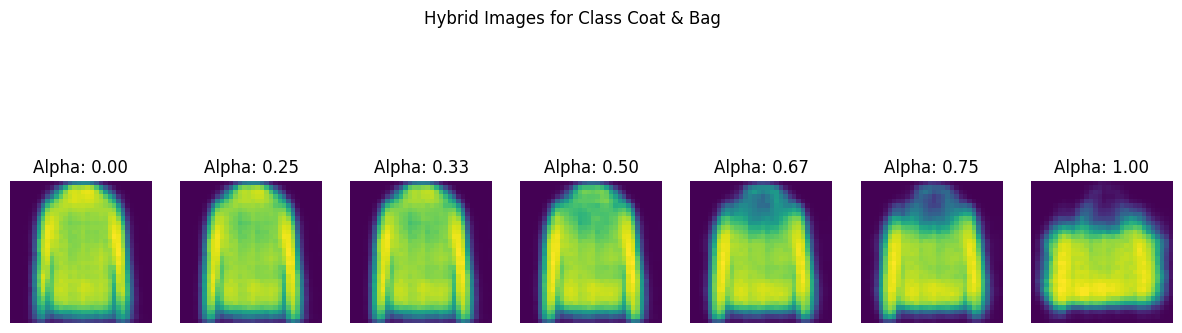

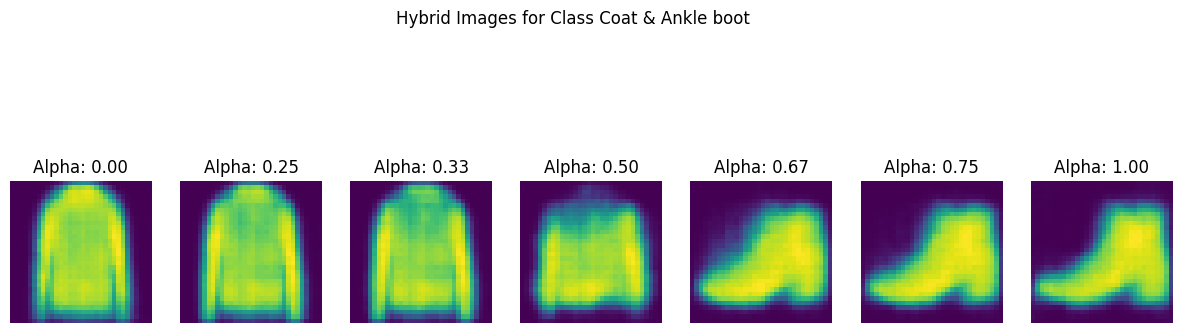

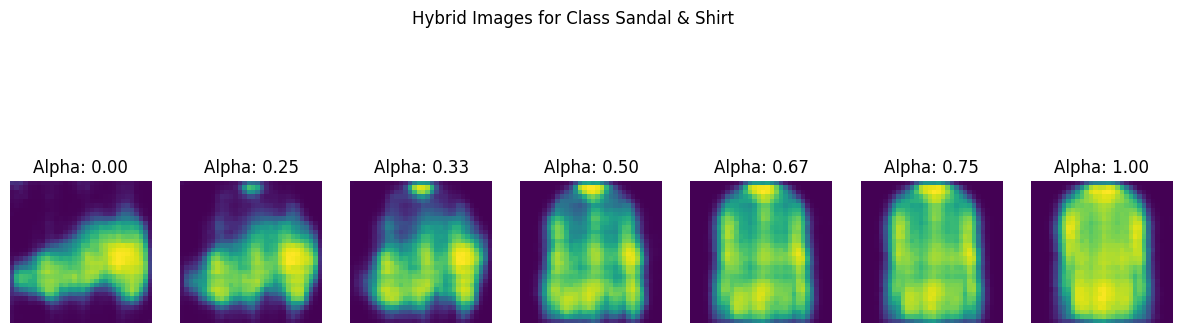

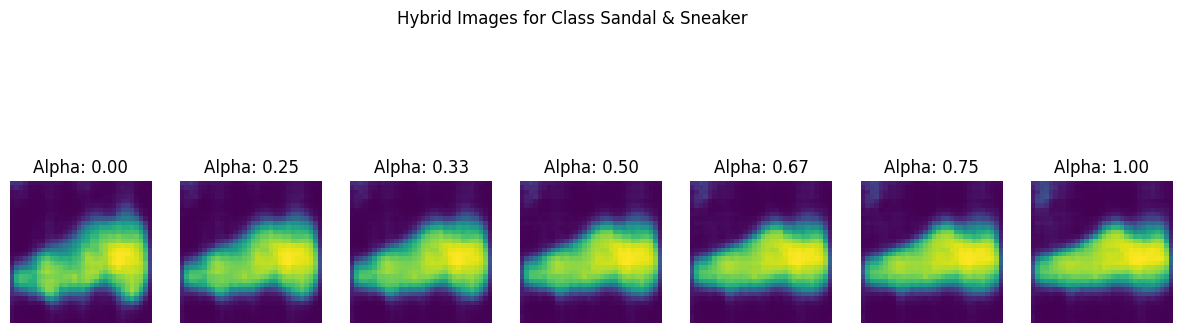

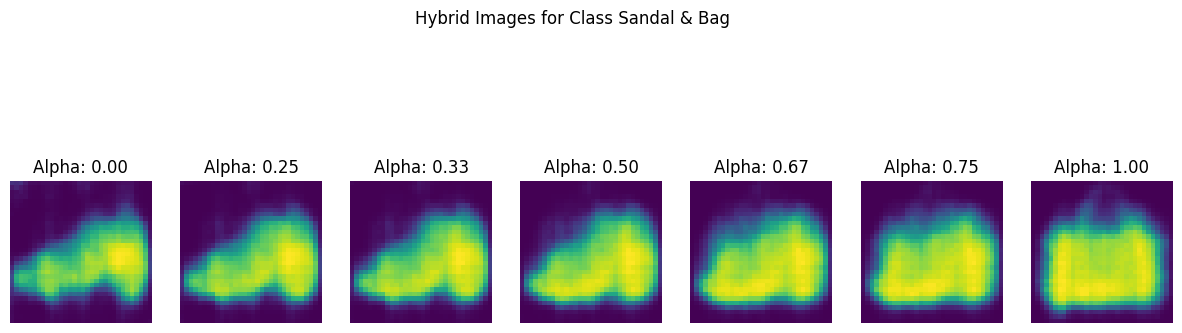

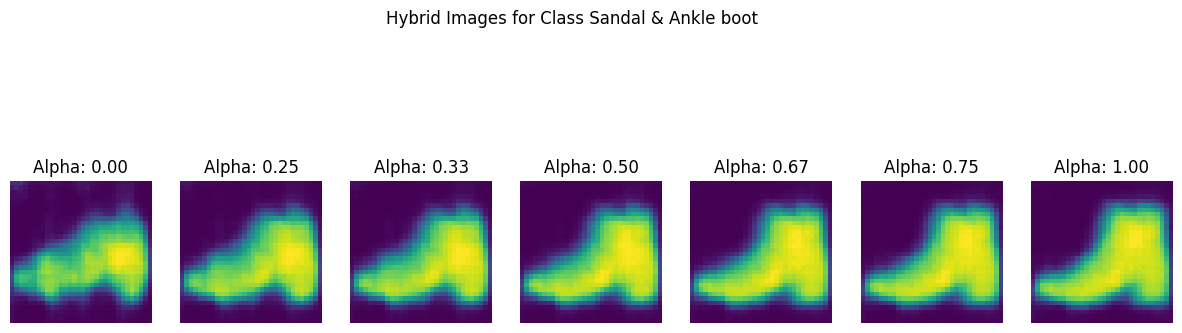

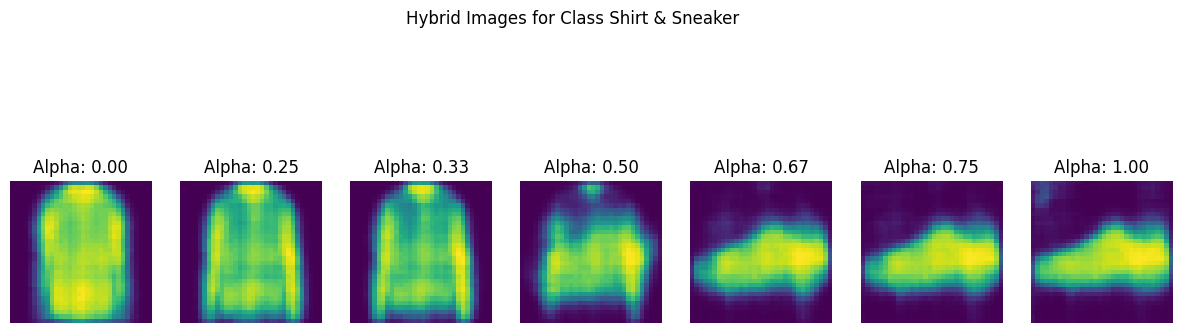

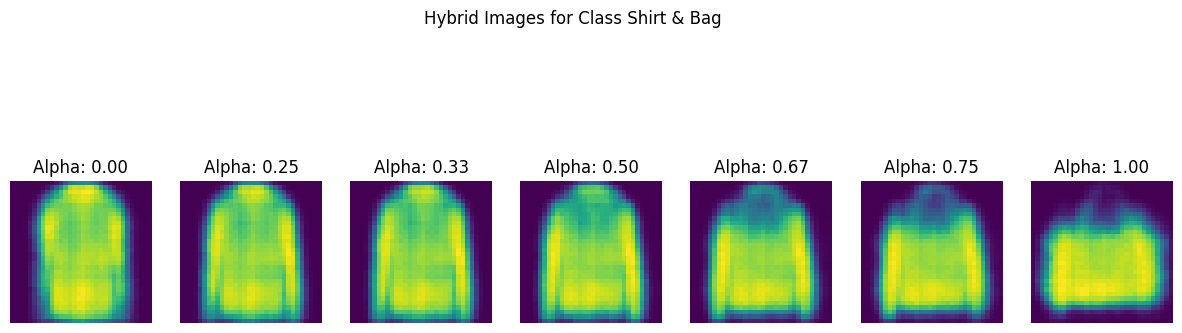

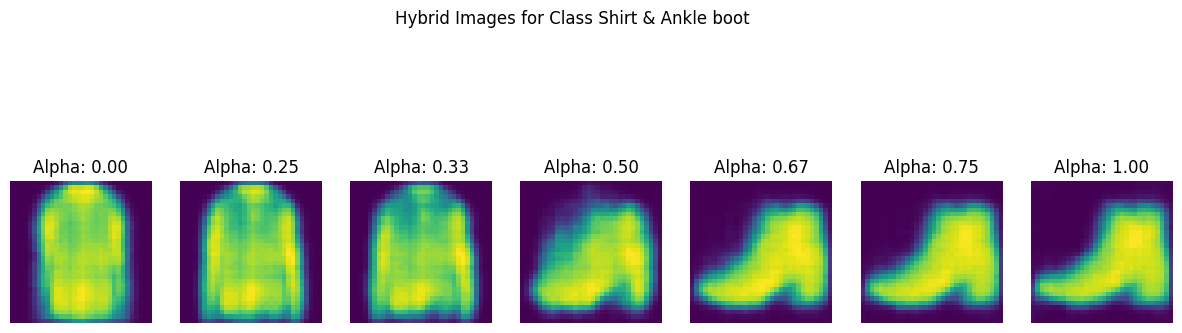

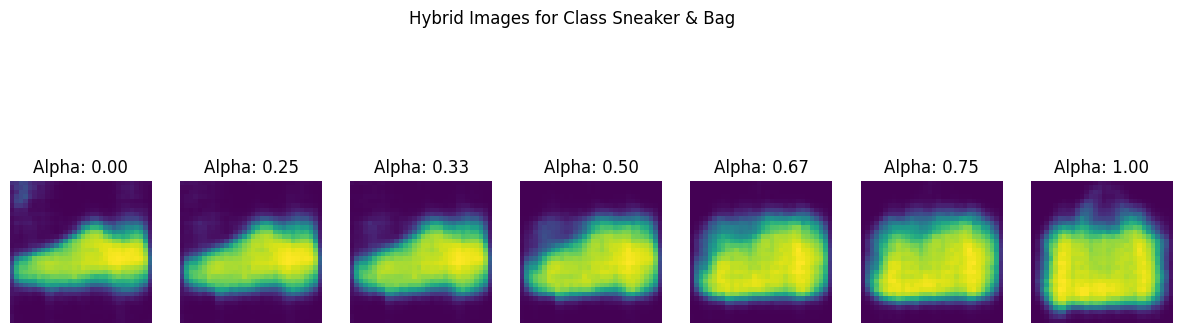

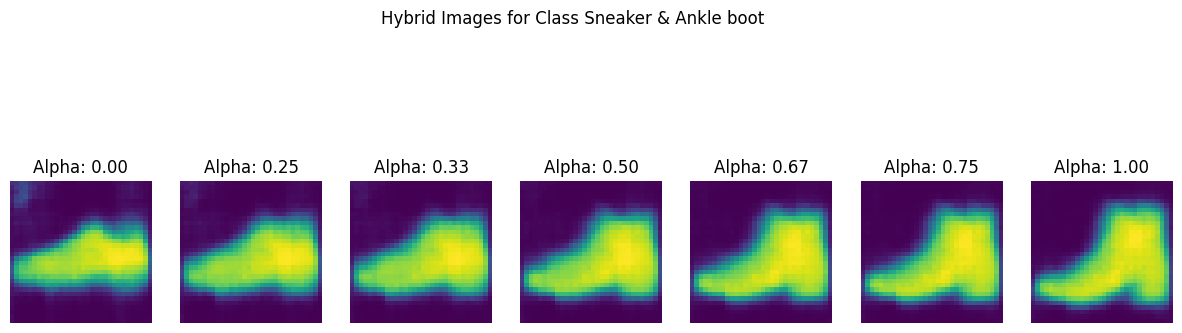

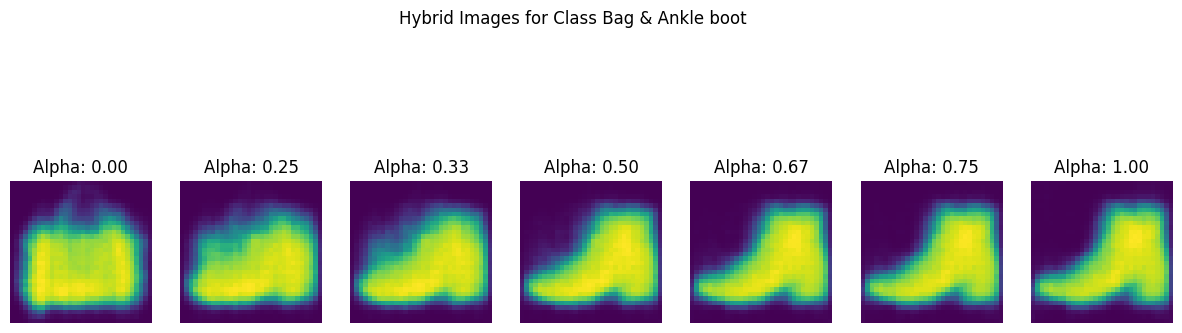

In [26]:
for (label1, label2) in label_combinations:
    centroid1 = centroids[label1]
    centroid2 = centroids[label2]

    alphas = [0, 0.25, 1/3, 1/2, 2/3, 0.75, 1]
    fig, axes = plt.subplots(1, len(alphas), figsize=(15, 5))
    fig.suptitle('Hybrid Images for Class {} & {}'.format(Label[label1], Label[label2]))

    for i, alpha in enumerate(alphas):
        interpolated_latent = interpolate_centroids(centroid1, centroid2, alpha)
        reconstructed_image = decode_latent(interpolated_latent, model)
        axes[i].imshow(reconstructed_image[0].cpu().detach().squeeze())  
        axes[i].set_title(f'Alpha: {alpha:.2f}')
        axes[i].axis('off')

    plt.show()


## Step 7: Challenge Exercise: Reimplement with CIFAR-100

Now that you've successfully implemented the Autoencoder for Fashion MNIST, your next challenge is to apply the same pipeline to the **CIFAR-100 dataset**. This dataset contains 100 classes of images, each with diverse objects, making it more challenging than Fashion MNIST.

### Your Tasks:
1. Preprocess the CIFAR-100 dataset, ensuring the images are appropriately normalized and resized if needed.
2. Redefine the Autoencoder architecture to accommodate CIFAR-100's RGB images (3 channels).
3. Train the Autoencoder on CIFAR-100 and visualize the reconstructed images.
4. Compute class centroids in the latent space for selected CIFAR-100 classes (choose a manageable subset, such as 10 classes).
5. Generate hybrid images by interpolating between class centroids in the latent space.
6. Visualize the latent space clustering for the selected CIFAR-100 classes using PCA or t-SNE.

This exercise will test your understanding of the Autoencoder pipeline and challenge you to work with a more complex dataset.


In [9]:
train_dataset2 = datasets.CIFAR100(root='./data_CIFAR100', train=True, download=True, transform=transform)
test_dataset2 = datasets.CIFAR100(root='./data_CIFAR100', train=False, download=True, transform=transform)

train_loader2 = DataLoader(dataset=train_dataset2, batch_size=64, shuffle=True)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=64, shuffle=False)

for images, labels in train_loader2:
    print(f'Image batch dimensions: {images.shape}')
    print(f'Label batch dimensions: {labels.shape}')
    break  

Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 32, 32])
Label batch dimensions: torch.Size([64])


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
model2 = BetaVAE(3, 10, loss_type="H").to(device)

In [30]:
class TestVAE2(unittest.TestCase):

    def setUp(self) -> None:
        # self.model2 = VAE(3, 10)
        self.model = BetaVAE(3, 10, loss_type='H').to(device)

    def test_summary(self):
        print(summary(self.model, (3, 32, 32), device=device))
        # print(summary(self.model2, (3, 64, 64), device='cpu'))

    def test_forward(self):
        x = torch.randn(64, 3, 32, 32).to(device)
        y = self.model(x)
        print("Model Output size:", y[0].size())
        # print("Model2 Output size:", self.model2(x)[0].size())

    def test_loss(self):
        x = torch.randn(64, 3, 32, 32).to(device)

        result = self.model(x)
        loss = self.model.loss_function(*result, M_N = 0.005)
        print(loss)


test_vae2 = TestVAE2()
test_vae2.setUp()
test_vae2.test_summary()
test_vae2.test_forward()
test_vae2.test_loss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Linear-10                   [-1, 10]          20,490
           Linear-11                   [-1, 10]          20,490
           Linear-12                 [-1, 2048]          22,528
  ConvTranspose2d-13             [-1, 64, 8, 8]          73,792
      BatchNorm2d-14             [-1, 6

In [31]:
for batch_idx, (data, _) in enumerate(train_loader2):
    data=data.to(device)
    print(len(model2(data)[0][0]))
    print(len(data[0]))
    print(model2(data)[0].shape)
    break

3
3
torch.Size([64, 3, 32, 32])


In [12]:
num_epochs = 3
for epoch in range(num_epochs):
    model2.train()
    total_loss2 = 0
    for data, _ in tqdm(train_loader2):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, _, mu, log_var = model2(data)
        loss2 = model2.loss_function(recon_batch, data, mu, log_var, M_N=0.005)
        loss2["loss"].backward()
        optimizer.step()
        total_loss2 += loss2['loss'].item()
        
    print(f'Epoch {epoch+1}, Loss: {total_loss2 / len(train_loader2)}')

100%|██████████| 782/782 [00:07<00:00, 109.11it/s]


Epoch 1, Loss: 0.4031943435330525


100%|██████████| 782/782 [00:07<00:00, 104.73it/s]


Epoch 2, Loss: 0.40316690329243154


100%|██████████| 782/782 [00:10<00:00, 77.48it/s]

Epoch 3, Loss: 0.40322173316307997


In [13]:
class_labels = train_dataset2.classes
print(class_labels)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [14]:
Label2 = {i: label for i, label in enumerate(class_labels)}
    
print(Label2)

{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 70: 'rose', 

mountain


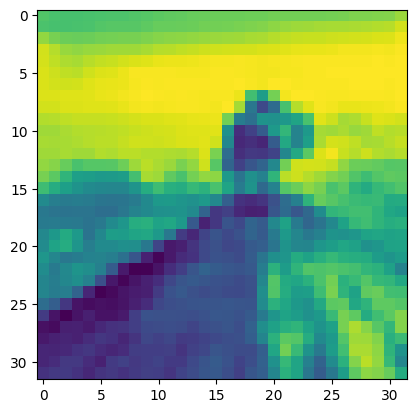

In [15]:
img, class_idx = next(iter(test_loader2))
plt.imshow(img[0][0])
print(Label2[class_idx[0].item()])

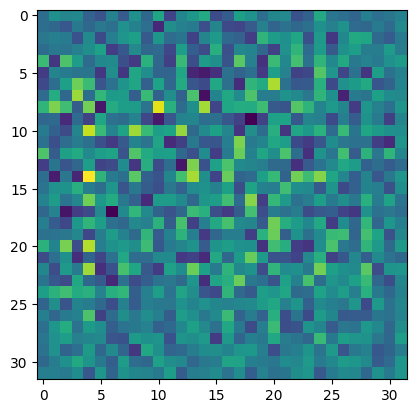

In [16]:
y = model2.generate(img.to(device))
plt.imshow(y.to('cpu').detach().numpy()[0][0])

In [17]:
class_latent_representations2 = {}

for data, labels in train_loader2:
    data = data.to(device) 
    labels = labels.to(device)
    
    mu2, logvar2 = model2.encode(data)
    latents2 = model2.reparameterize(mu2, logvar2)
    
    for label in torch.unique(labels)[:10]:
        label_latents2 = latents2[labels == label]
        if label.item() not in class_latent_representations2:
            class_latent_representations2[label.item()] = label_latents2
        else:
            class_latent_representations2[label.item()] = torch.cat((class_latent_representations2[label.item()], label_latents2))

In [18]:
centroids2 = {label: torch.mean(latents, dim=0) for label, latents in class_latent_representations2.items()}
print(centroids2)

{0: tensor([ 0.4353,  0.3518,  0.3053, -0.2214,  0.2711,  0.0836, -0.0145,  0.2290,
         0.2068,  0.1080], device='cuda:0', grad_fn=<MeanBackward1>), 2: tensor([ 0.4679,  0.0960,  0.1498, -0.0118,  0.4178,  0.1266, -0.1008,  0.1128,
         0.2070,  0.2685], device='cuda:0', grad_fn=<MeanBackward1>), 6: tensor([ 0.3707,  0.2943,  0.2164, -0.1464,  0.3433,  0.0956,  0.0117,  0.2716,
         0.1654,  0.1961], device='cuda:0', grad_fn=<MeanBackward1>), 14: tensor([ 0.4526,  0.3249,  0.1252, -0.1802,  0.4971,  0.1987, -0.0464,  0.1722,
         0.2172,  0.2184], device='cuda:0', grad_fn=<MeanBackward1>), 16: tensor([ 0.4336,  0.2602,  0.2567, -0.1652,  0.3135,  0.0711, -0.0013,  0.0058,
         0.0904,  0.0972], device='cuda:0', grad_fn=<MeanBackward1>), 17: tensor([ 0.4411,  0.4042,  0.3864, -0.4064,  0.3182, -0.0627, -0.0630, -0.2226,
         0.2839,  0.0872], device='cuda:0', grad_fn=<MeanBackward1>), 18: tensor([ 0.3165,  0.2334,  0.0866, -0.1495,  0.5442,  0.0827, -0.1809,  0.

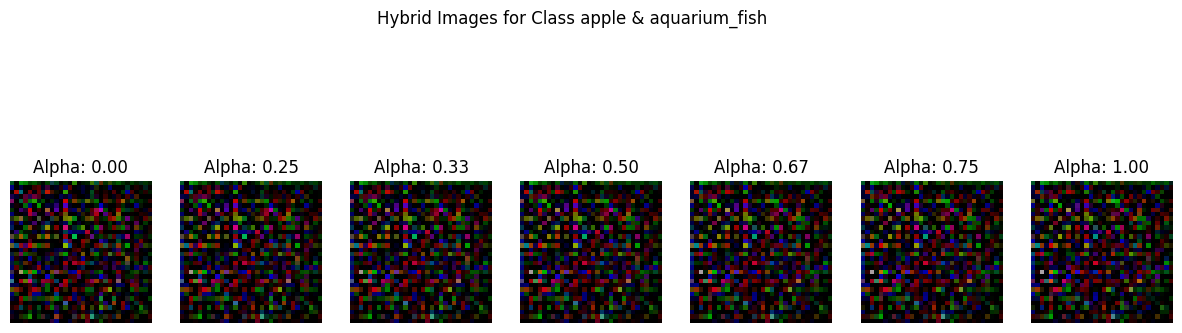

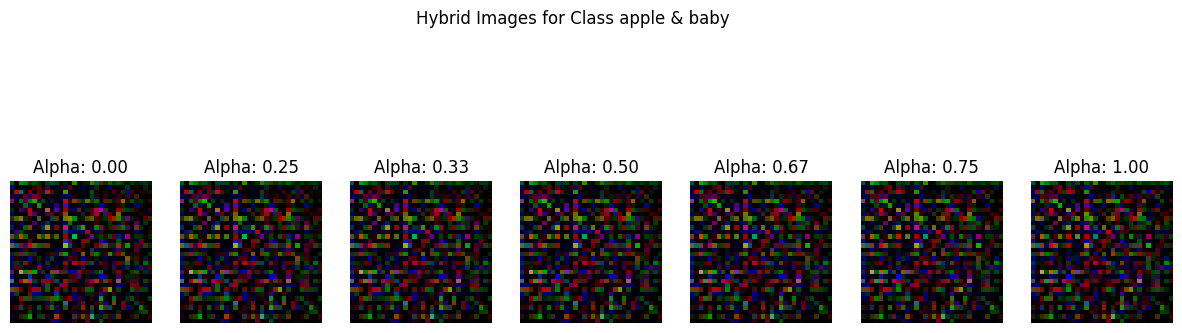

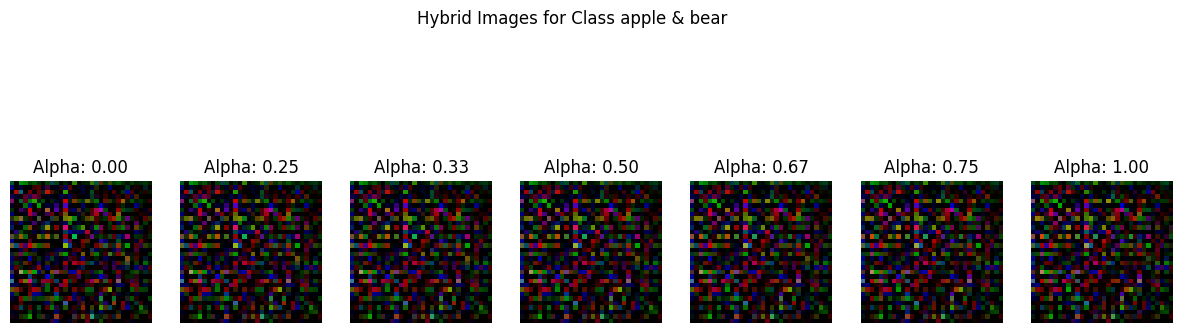

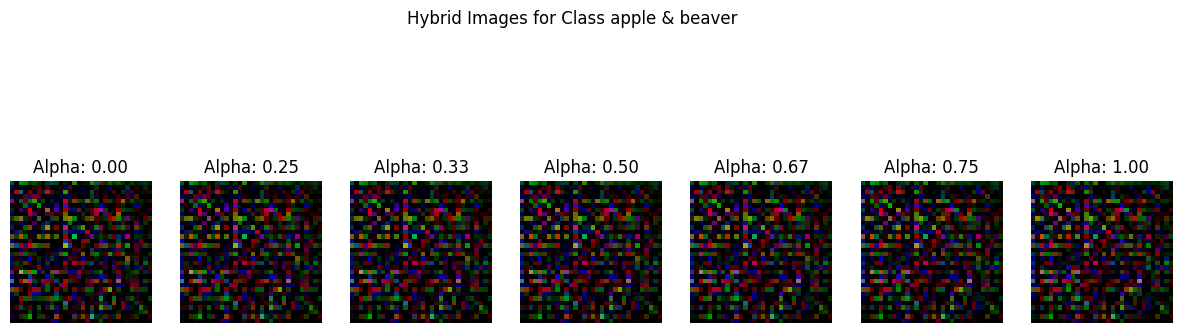

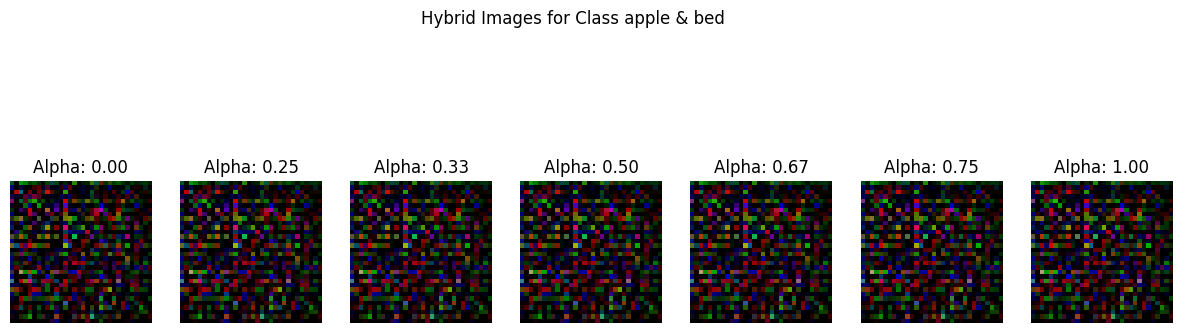

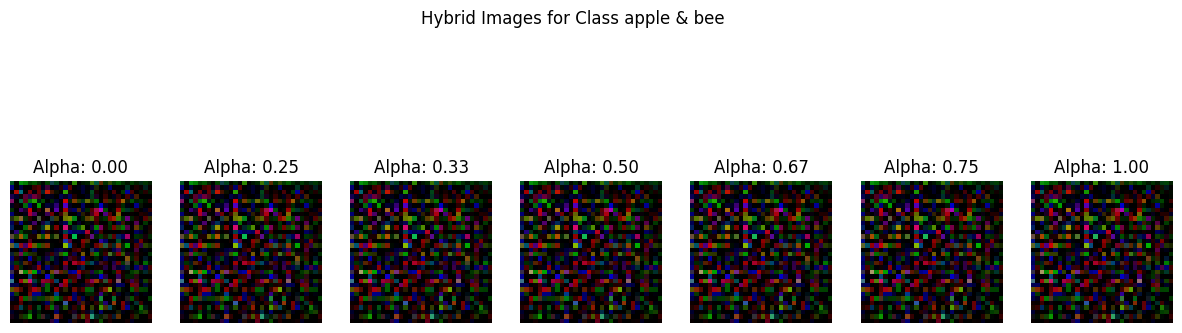

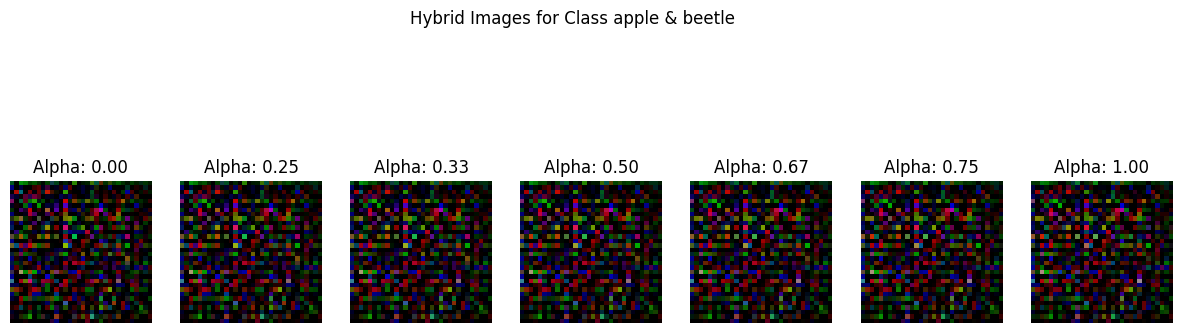

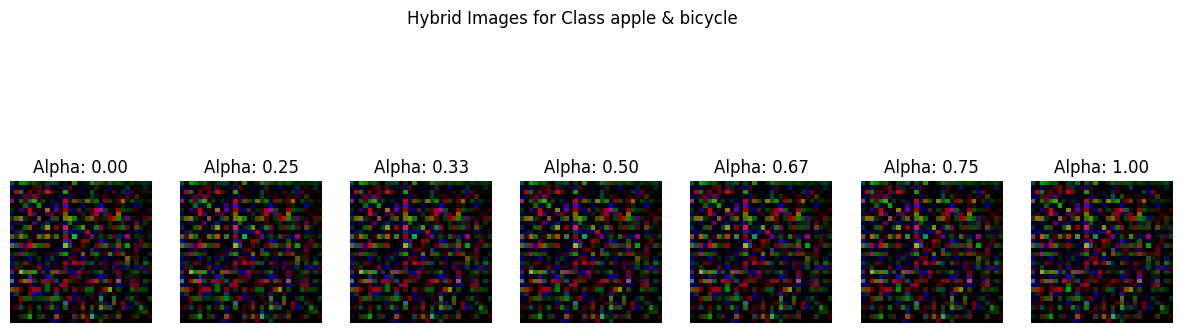

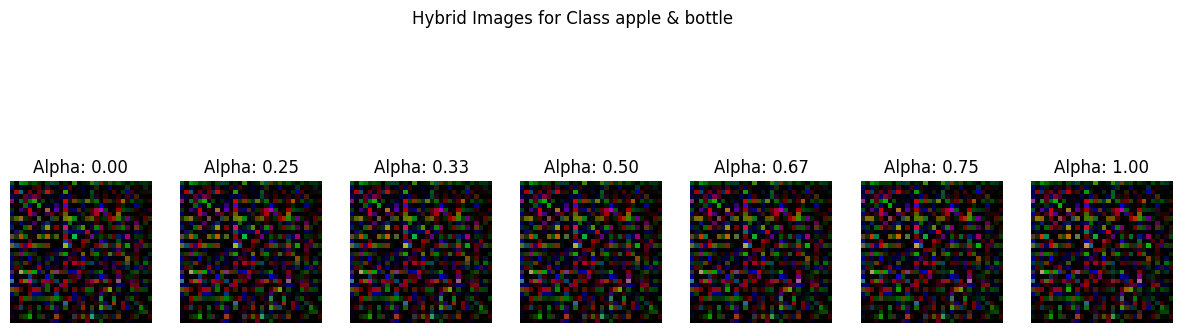

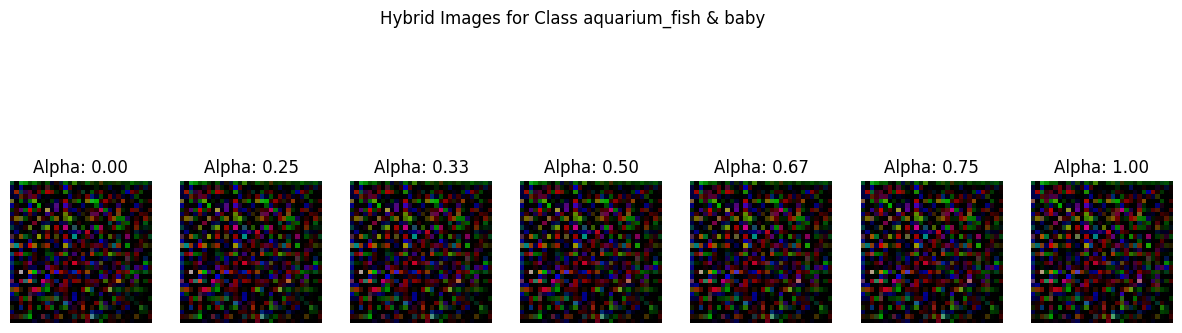

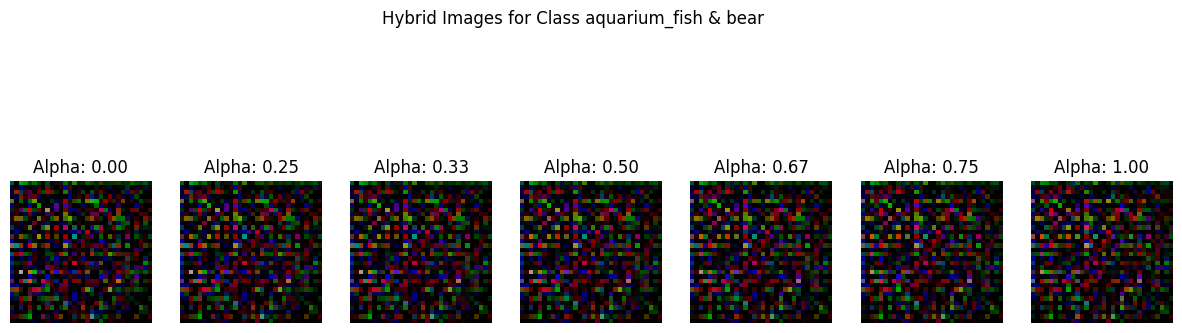

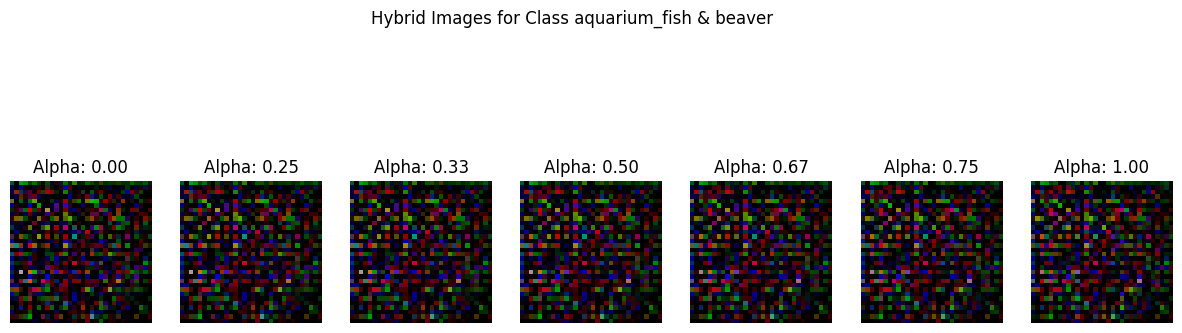

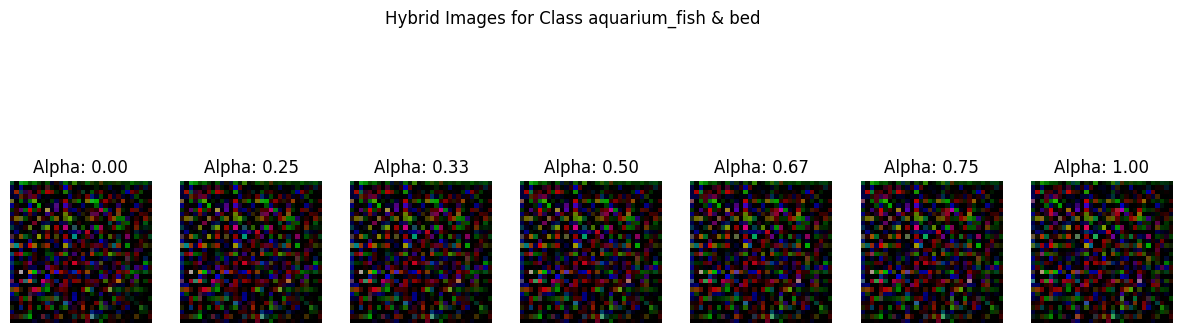

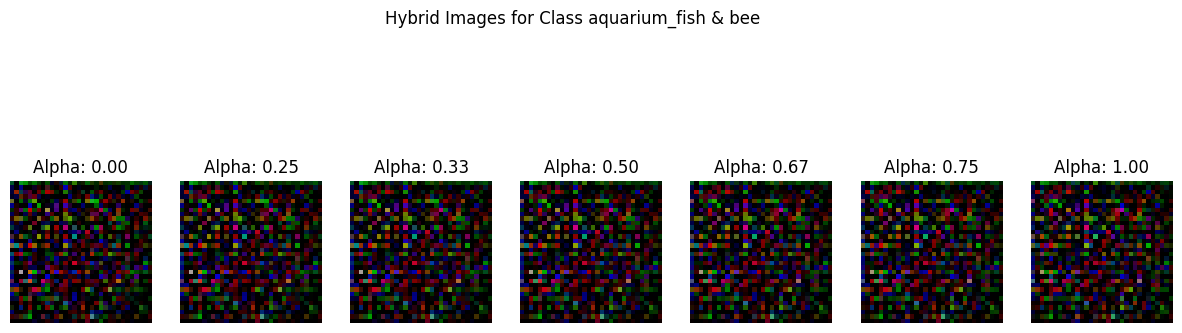

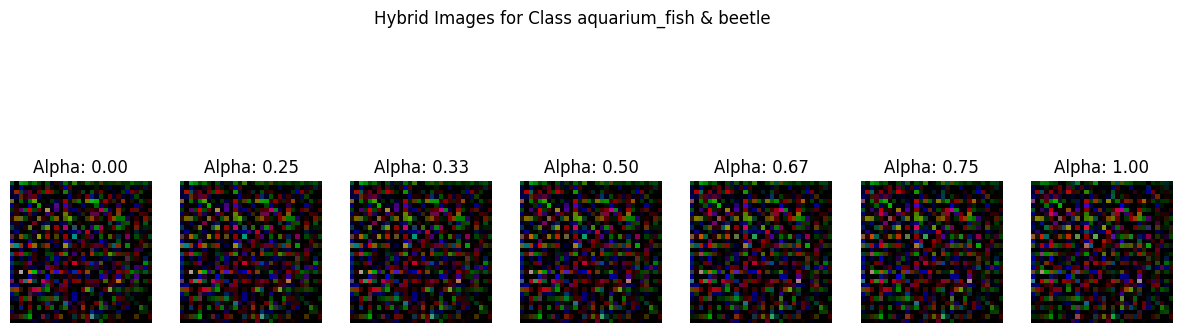

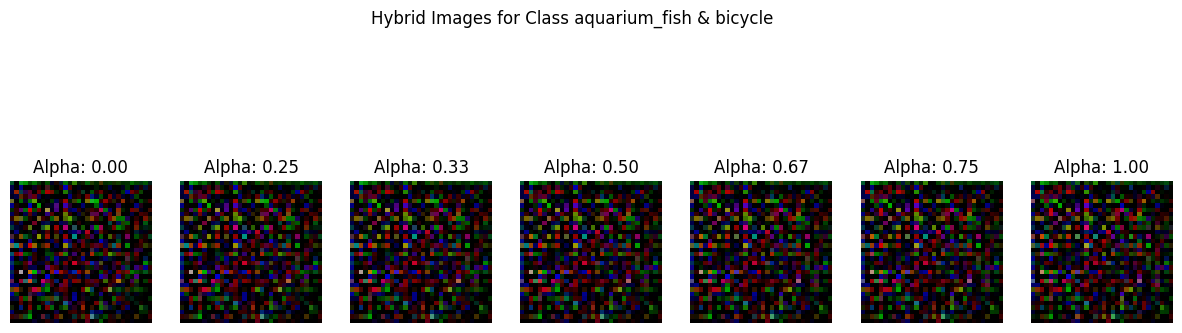

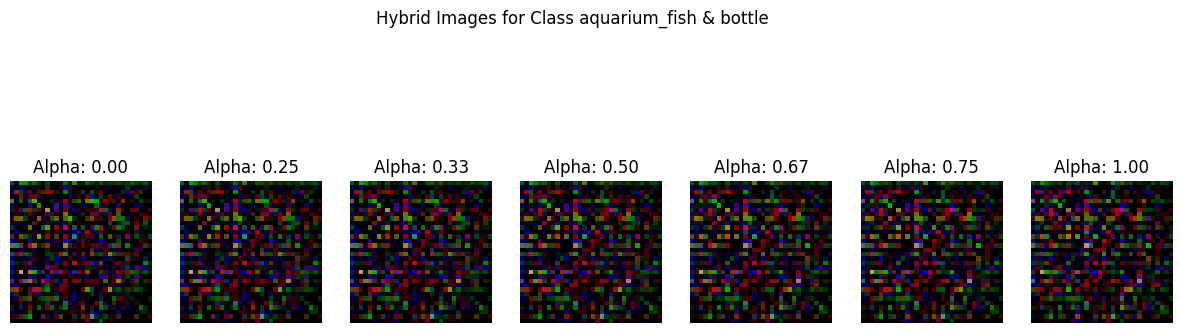

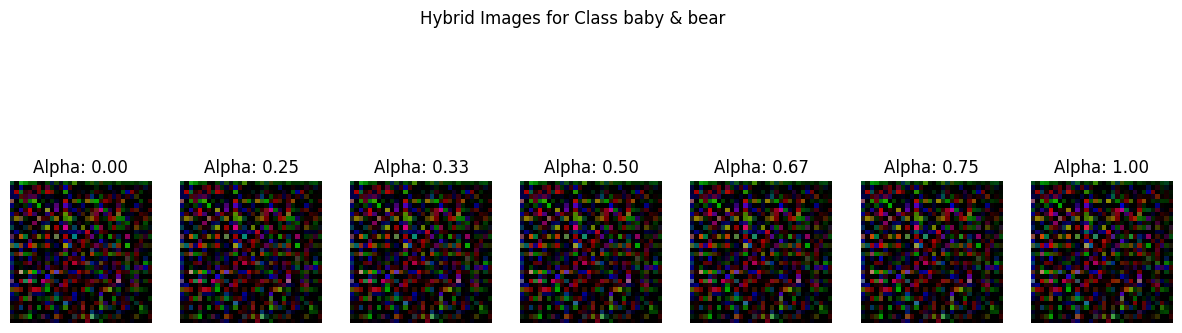

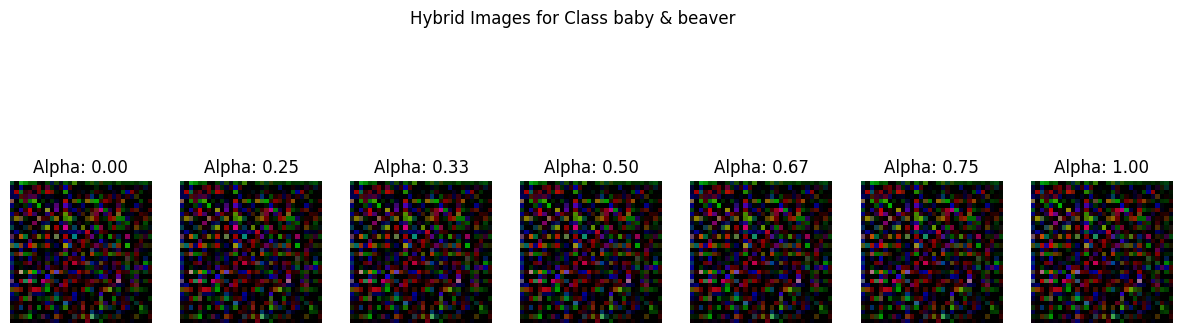

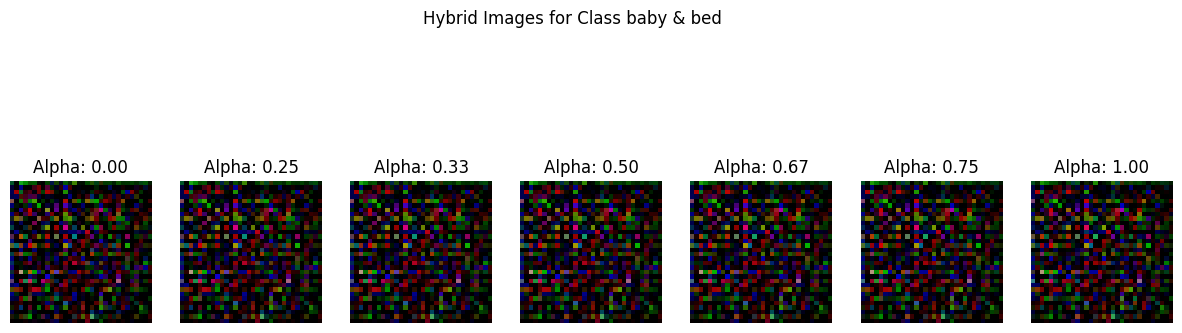

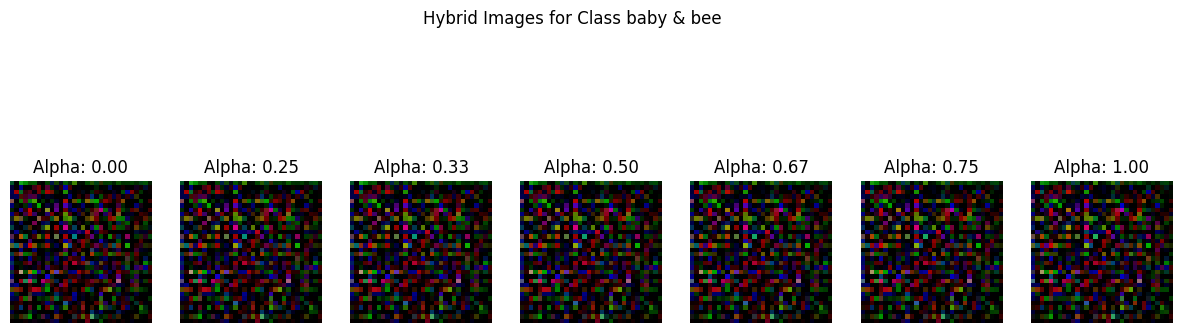

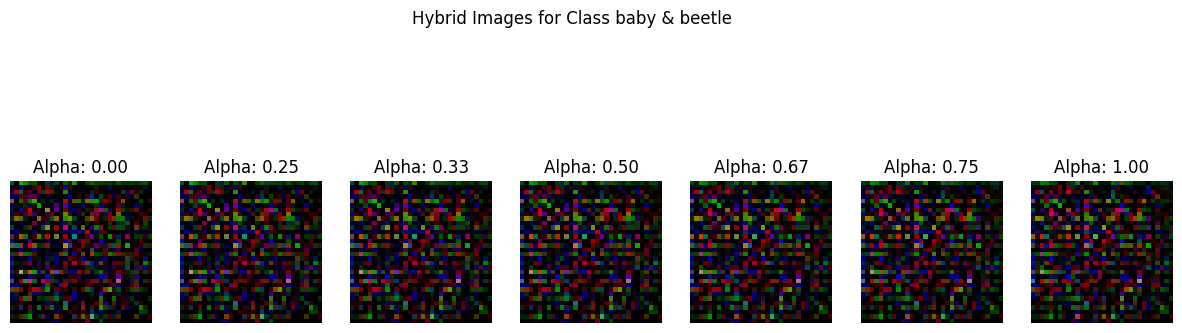

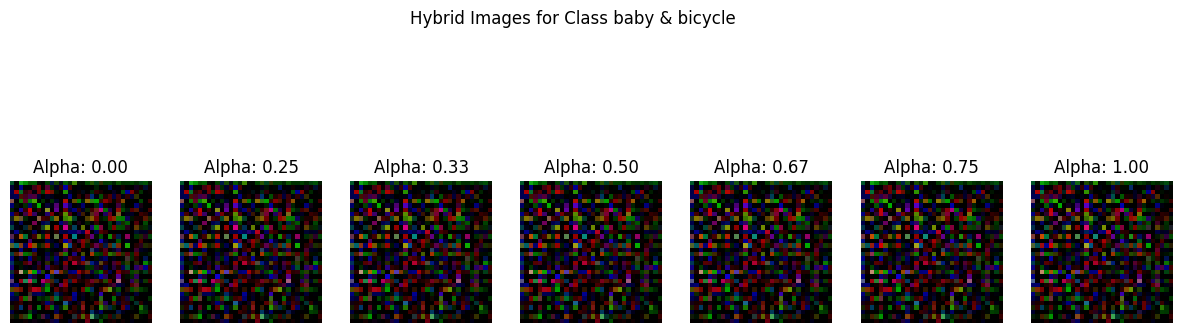

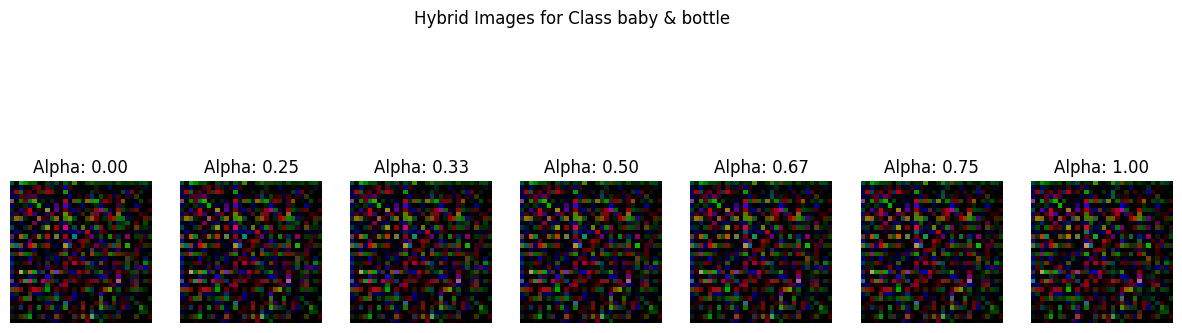

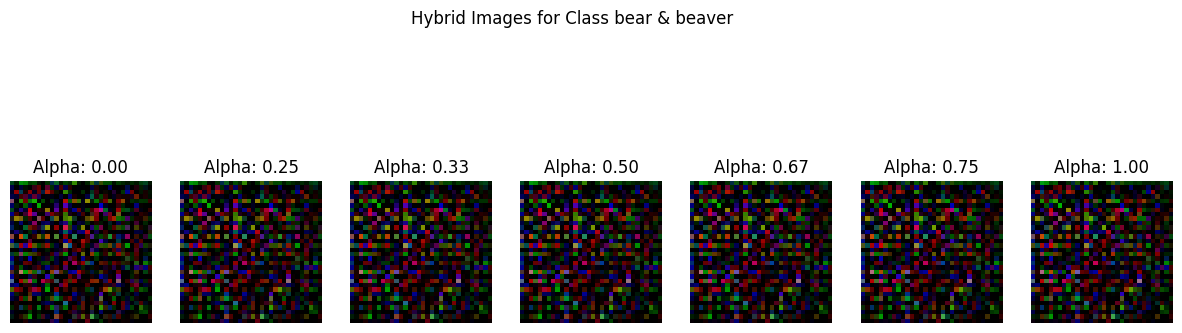

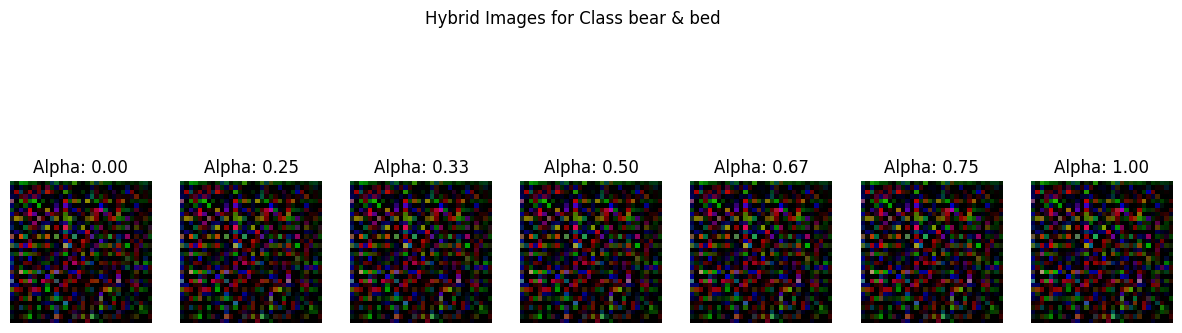

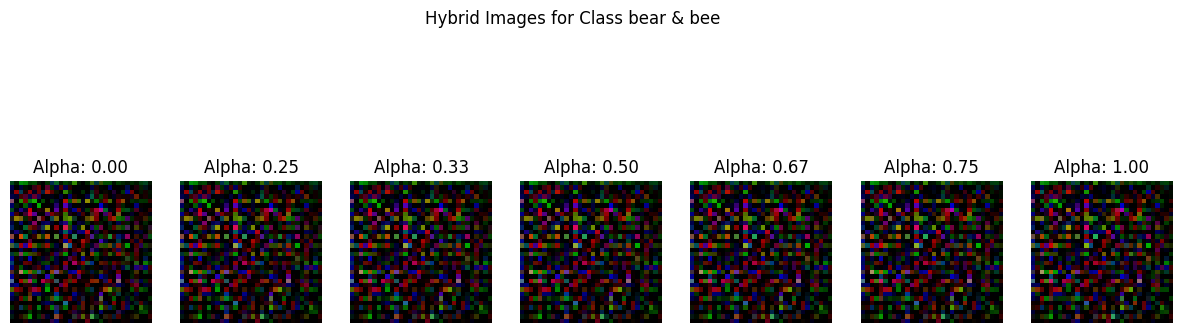

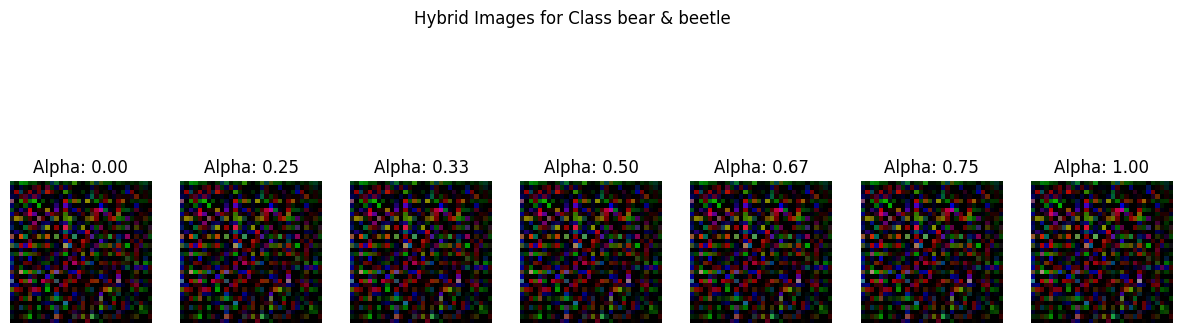

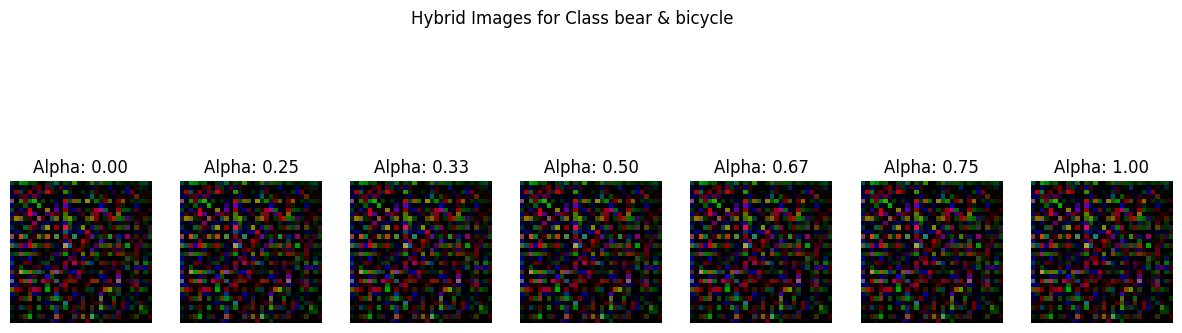

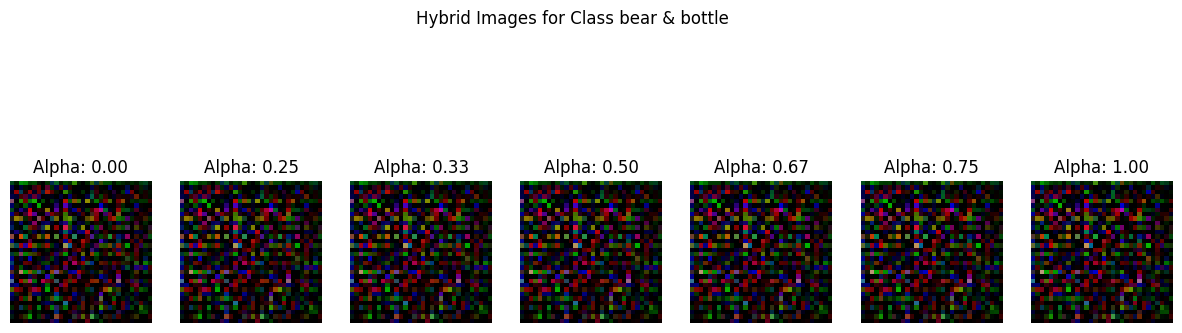

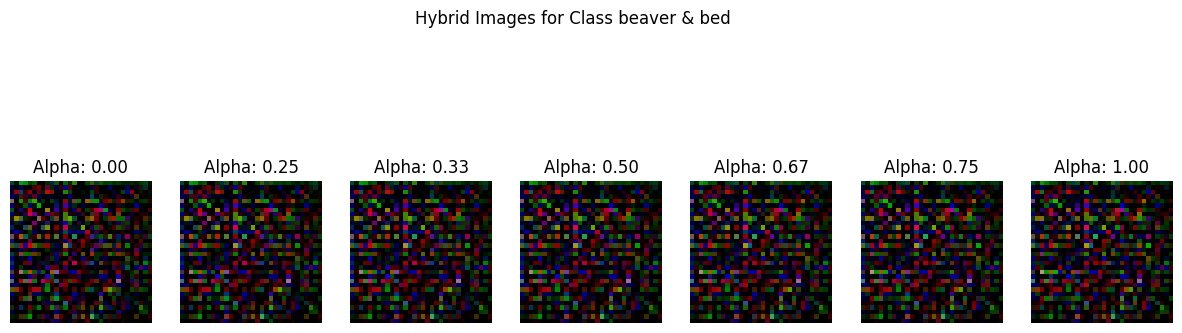

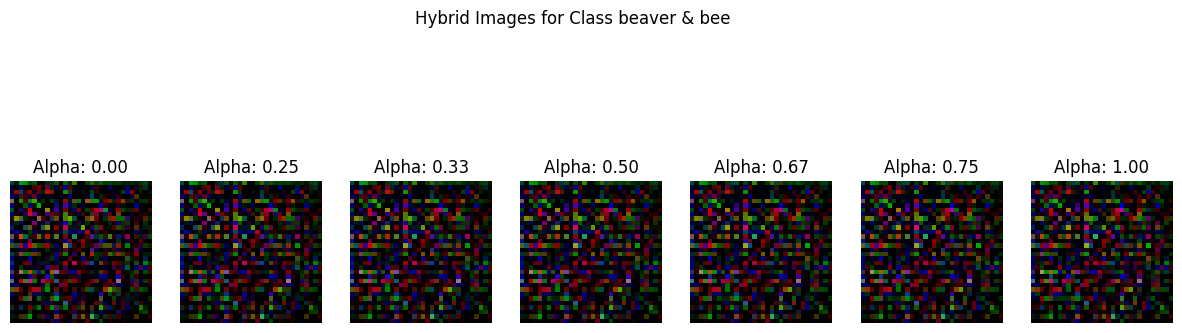

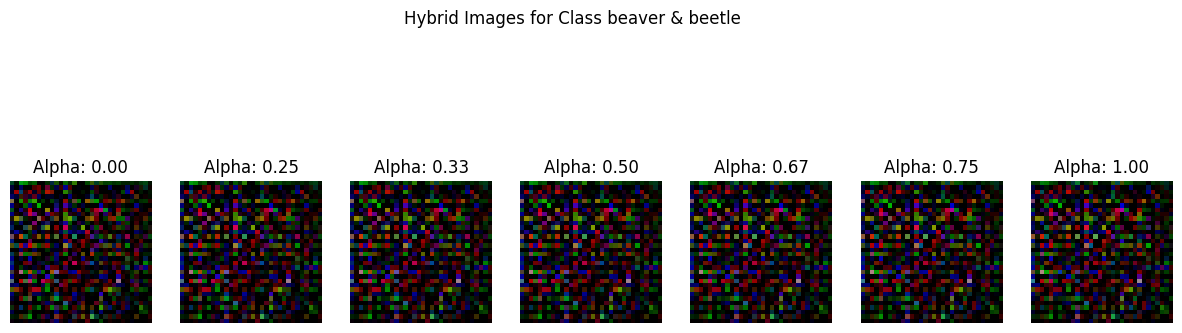

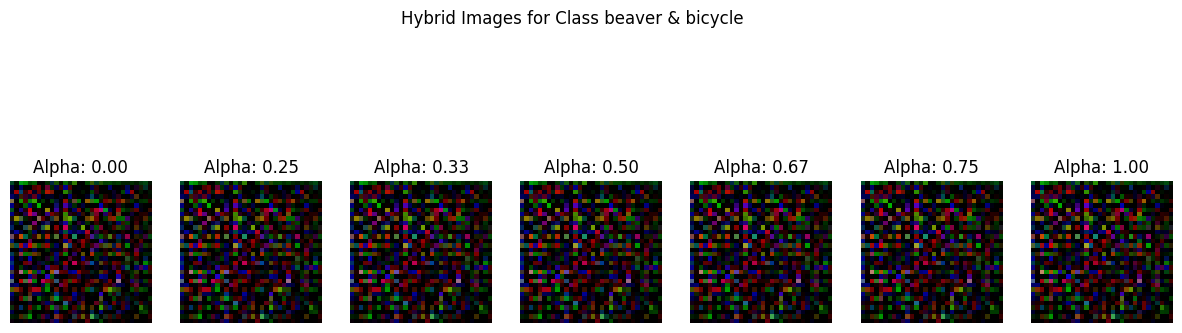

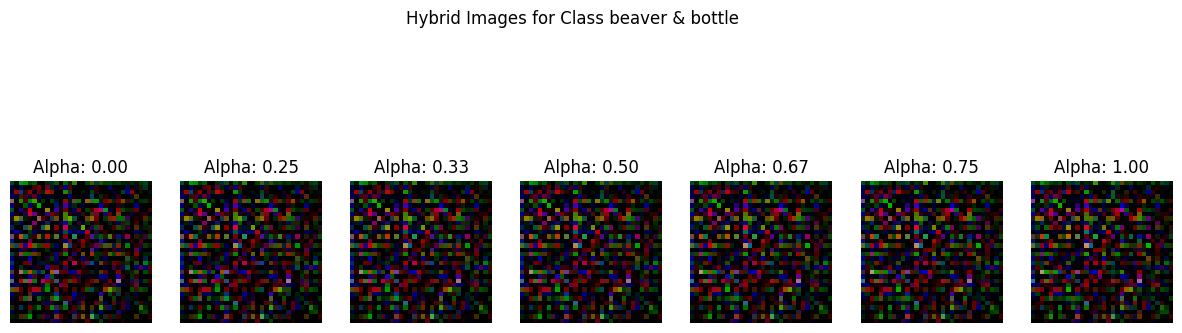

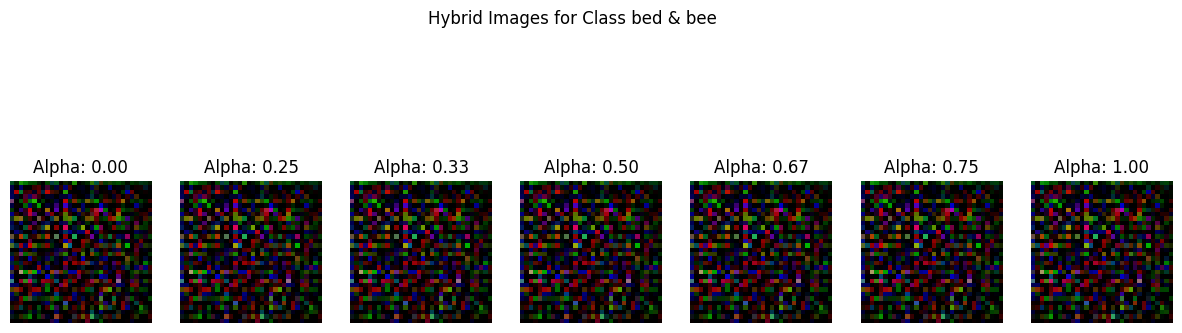

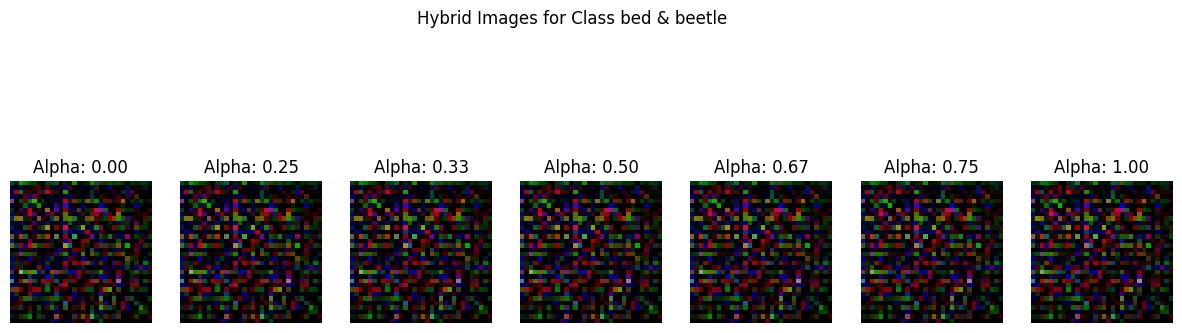

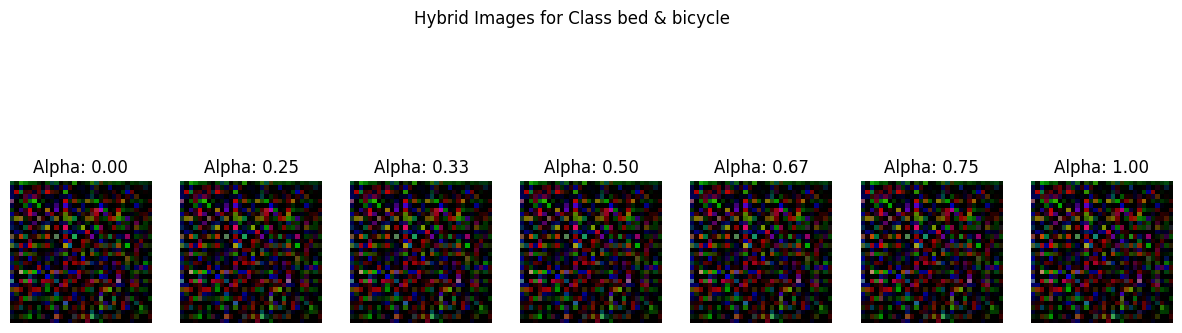

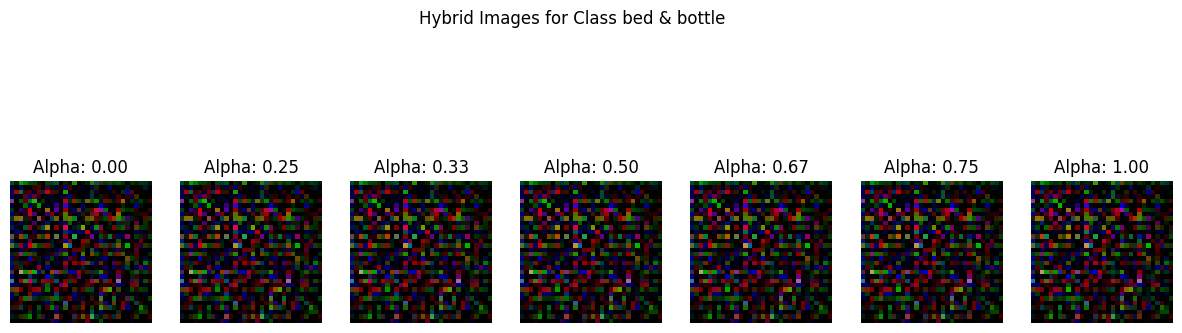

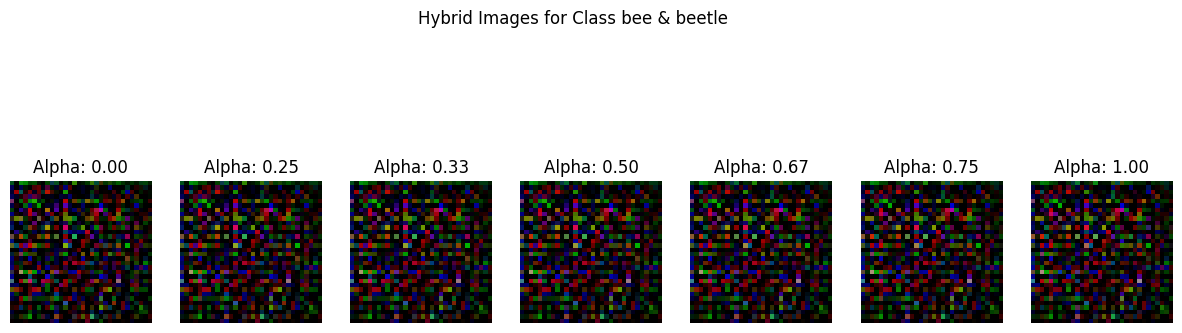

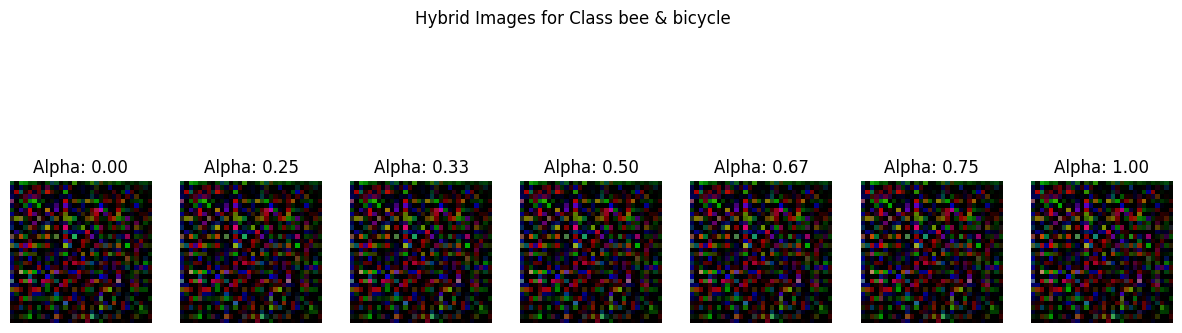

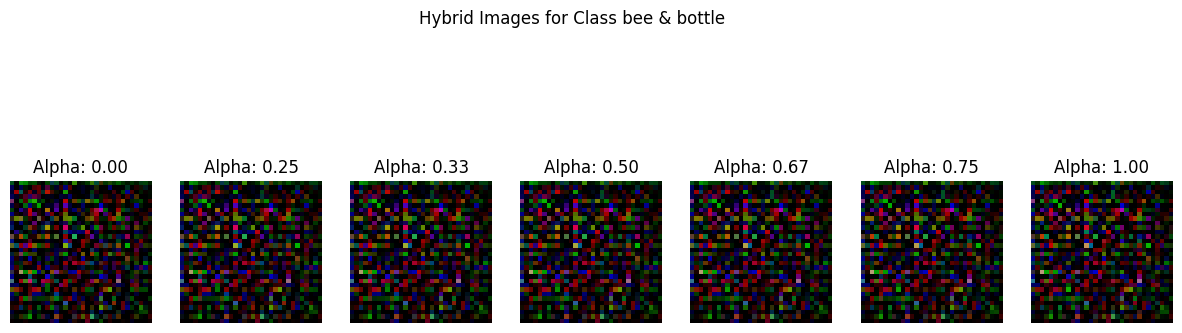

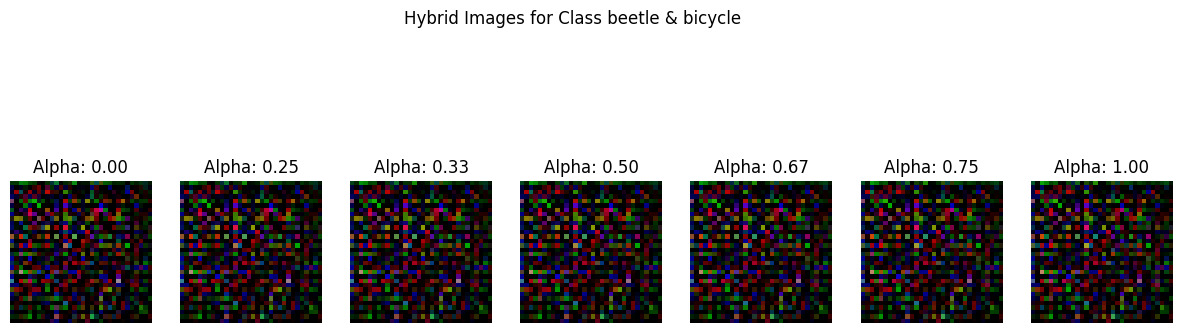

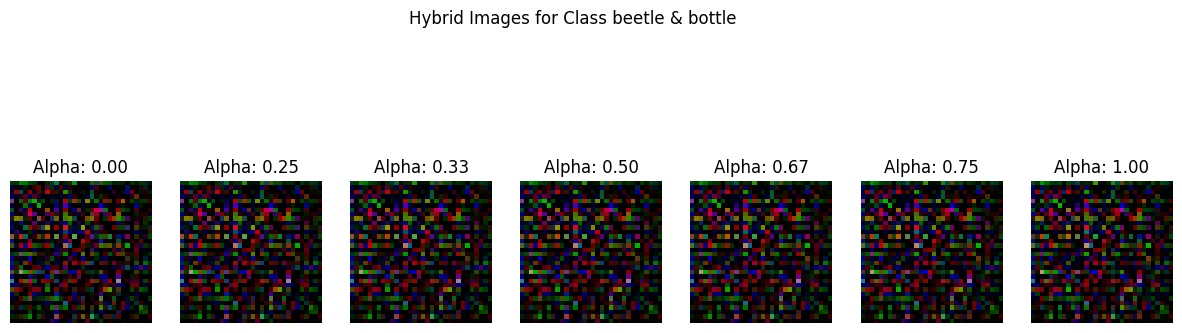

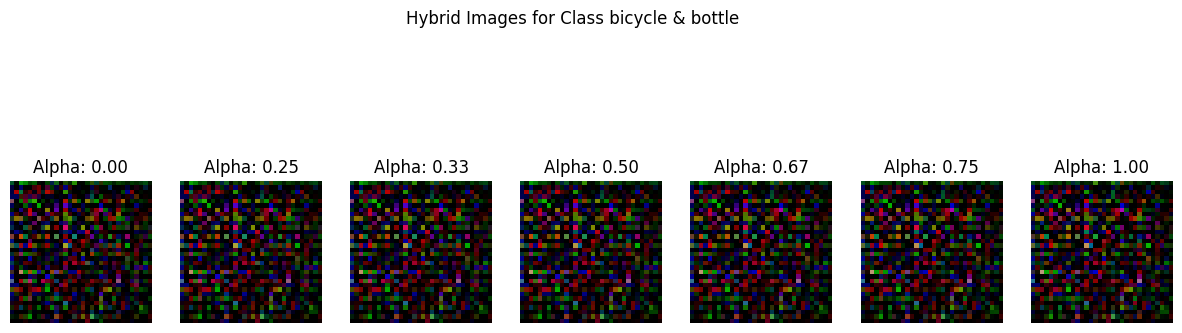

In [28]:
for (label1, label2) in label_combinations:
    centroid1 = centroids2[label1]
    centroid2 = centroids2[label2]

    alphas = [0, 0.25, 1/3, 1/2, 2/3, 0.75, 1]
    fig, axes = plt.subplots(1, len(alphas), figsize=(15, 5))
    fig.suptitle('Hybrid Images for Class {} & {}'.format(Label2[label1], Label2[label2]))

    for i, alpha in enumerate(alphas):
        interpolated_latent = interpolate_centroids(centroid1, centroid2, alpha)
        reconstructed_image = decode_latent(interpolated_latent, model2)
        reconstructed_image = torch.clamp(reconstructed_image, 0, 1)
        axes[i].imshow(reconstructed_image[0].permute(1, 2, 0).cpu().detach().squeeze())  
        axes[i].set_title(f'Alpha: {alpha:.2f}')
        axes[i].axis('off')

    plt.show()

In [30]:
datas2 = []
labels2 = []
for data, target in train_loader2.dataset:
    datas2.append(data)
    labels2.append(target)

datas2 = torch.stack(datas2).to(device)  

mu2, logvar2 = model2.encode(datas2)
preds_latent2 = model2.reparameterize(mu2, logvar2)

tsne2 = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results_reparam2 = tsne2.fit_transform(preds_latent2.detach().cpu().numpy())

/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.034s...
[t-SNE] Computed neighbors for 50000 samples in 10.719s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [39]:
num_samples = 3000

indices = np.random.choice(len(tsne_results_reparam2), num_samples, replace=False)
tsne_results_reparam_sampled2 = tsne_results_reparam2[indices]
labels_sampled2 = np.array(labels2)[indices]

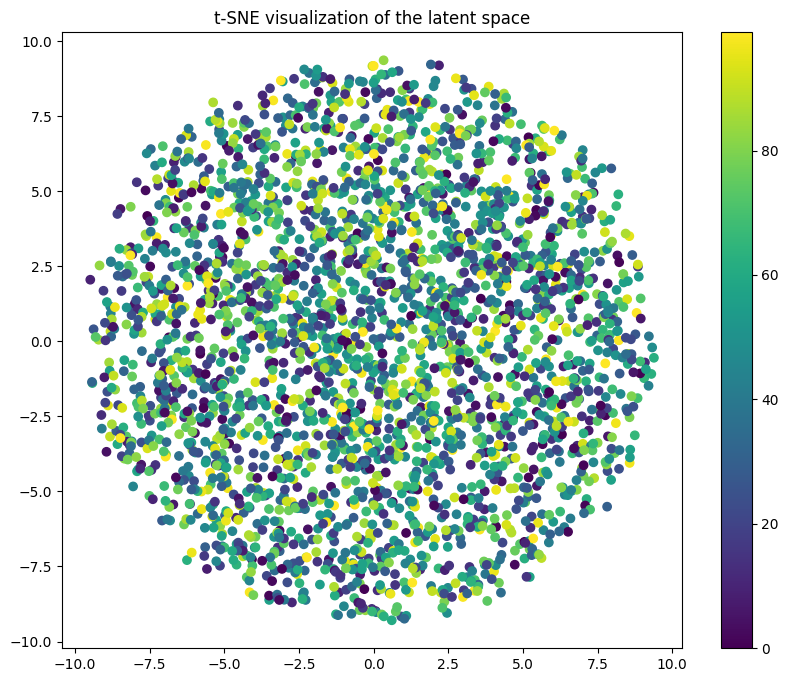

In [40]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results_reparam_sampled2[:, 0], tsne_results_reparam_sampled2[:, 1], c=labels_sampled2, cmap='viridis')
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', cmap='viridis', s=50, ) 
# for i, (x, y) in enumerate(cluster_centers):
#     plt.text(x, y, f'Class {Label[i]}', fontsize=9, ha='center', va='center') 
plt.colorbar()
plt.title('t-SNE visualization of the latent space')
# plt.legend()
plt.show()

### REPORT
- Encountered difficulties: The model's learning performance on the CIFAR-100 dataset is not good; and the values of the three channels after hybriding exceed the [0,1] range, leading to strange results in the hybrid images.

- We have tried more models to learn CIFAR-100, but the results are all underwhelming; for another issue, we used `torch.clamp` to forcibly crop the range to [0,1], or attempted to change the range through linear transformation (the latter was abandoned), which was clearly not a wise move, as we did not identify the cause of the three-channel values exceeding the range.

- I believe these tasks are primarily designed to give students an in-depth understanding of the architecture of AE or VAE models and the operations or computations that occur in the latent space. For these tasks, we first searched the web for various excellent open-source models and ultimately used Beta_VAE. We then made some modifications to the open-source model to adapt it to our tasks. Before training the model each time, we tested it using the `unittest.TestCase` method to ensure that the model could accommodate the dataset. After training the model, we retrieved the first image of the first batch from the test set to compare the original and generated images. When analyzing the latent space, to prevent the compressed space from being cluttered, we used resampling and found the center of each class using the Kmeans method and displayed them. In the hybrid image generation phase, we first defined two functions, `interpolate_centroids` and `decode_latent`, to facilitate subsequent code. In the latent space, the selection of centroids can come from three categories: mu, var, and the results after sampling. We chose to select centroids from the space after sampling for hybrid generation. We selected 7 values of alpha and arranged all 10 types of Fashion MNIST data in pairs for hybrid generation, resulting in 7 * 45 different hybrid images, and the final effect was good. For the CIFAR-100 dataset, we did almost the same thing as before, but the results seem not very satisfactory.

- The potential issue lies in the shallow convolutional and transposed convolutional layers in our model, which can lead to difficulties when dealing with high-resolution and complex images. The model fails to extract complex features, resulting in poor quality in the latent space and, consequently, poor quality in the reconstructed images. Additionally, when the dataset contains many labels, I believe the current model may also struggle to cope. The class centroids in the latent space do not have a large enough distance between them, and different classes mix together after sampling and reconstruction, leading to generated images that are indistinguishable.



